## Setting up Colab Environment if in Colab

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os

    DRIVE_PATH = os.path.join(os.getcwd(),'drive')

    !pip install geopandas sparse-dot-topn pdpipe 
    import geopandas as gpd
    import sparse_dot_topn.sparse_dot_topn as ct
    import pdpipe as pdp


    if not 'Miniconda3-4.5.4-Linux-x86_64.sh' in os.listdir():
        !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

    if not ('EPFL-Capstone-Project' in os.listdir()) and (os.getcwd().split('/')[-1] != 'EPFL-Capstone-Project'):
        !git clone https://github.com/helmigsimon/EPFL-Capstone-Project  
    os.chdir('EPFL-Capstone-Project')

    !conda env create -f environment.yml
    !conda activate exts-ml

    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')

    def restart_runtime():
      os.kill(os.getpid(), 9)
        
    #Setting up RAPIDS AI

    import pynvml
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    device_name = pynvml.nvmlDeviceGetName(handle)
    if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
        print("Wrong GPU - Restarting Runtime")
        restart_runtime()


    # clone RAPIDS AI rapidsai-csp-utils scripts repo
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

    # install RAPIDS
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13

    import sys, os
    # set necessary environment variables 
    dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
    sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
    sys.path

    # update pyarrow & modules 
    exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())
    
except ModuleNotFoundError as e:
    print(e)
    print('Not in colab environment, continuing to run locally')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached geopandas-0.7.0-py2.py3-none-any.whl (928 kB)
Processing /root/.cache/pip/wheels/aa/e7/c7/e64559d518bcc12ed7e40a605ae304259b957ae8181c8d1e82/sparse_dot_topn-0.2.9-cp36-cp36m-linux_x86_64.whl
  Using cached pdpipe-0.0.46-py3-none-any.whl (47 kB)
  Using cached Fiona-1.8.13.post1-cp36-cp36m-manylinux1_x86_64.whl (14.7 MB)
  Using cached pyproj-2.6.0-cp36-cp36m-manylinux2010_x86_64.whl (10.4 MB)
     |████████████████████████████████| 1.8 MB 2.8 MB/s 
     |████████████████████████████████| 2.1 MB 71.5 MB/s 
  Using cached skutil-0.0.16-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 60 kB 8.0 MB/s 
  Using cached strct-0.0.30-py2.py3-none-any.whl (16 kB)
  Using cached cligj-0.5.0-py3-none-any.whl (5.7 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import pickle
import random
import umap
from tqdm import tqdm
from data.util.paths import DATA_PATH
from lib.util.paths import PIPELINE_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from lib.transformers import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
tqdm.pandas()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from lib.processing import *
from lib.pipelines import *
from data.scripts.project_data import DataLoader
from data.util.environment_variables import COUNTRY_CODES, M49_TO_ISO3
DATA_PATH = '/content/drive/My Drive/EPFL Capstone'

## Setting up Dataset

In [4]:
extracted_df, api_df = load_from_pkl('extracted',path=DATA_PATH), load_from_pkl('api',path=DATA_PATH)
extracted_df = extracted_pipe.fit_transform(extracted_df)
api_df = api_pipe.fit_transform(api_df)

In [ ]:
df = pd.merge(extracted_df,api_df,on='release_id')

In [ ]:
del extracted_df, api_df

## Create Column Store

In [ ]:
col_set = {
    'format': {
        'description': 'format_description_', 
        'name': 'format_name_', 
        'text': ('format_text_clean'),
        'quantity': ('format_quantity')
    },
    'geography': {
        'superregion': 'superregion_',
        'region': 'region_',
        'country': 'country_'
    },
    'timeperiod': {
        'period': 'period_',
        'era': 'era_'
    },
    'genre': 'genre_',
    'style': 'style_',
    'null': None,
    'indicator': lambda x: x.max() == 1 and x.min() == 0
}

In [8]:
column_store = ColumnStore()
column_store.fit(df,col_set)

## Overview of Number of Records over Time

In [ ]:
period_year_range, era_year_range = make_year_range_dict(column_store._timeperiod_period,df=df), make_year_range_dict(column_store._timeperiod_era,df=df)
time_period_year_range = dict(**period_year_range,**era_year_range)

In [ ]:
year_count_series = df.groupby(by='year')['market_value'].count()
year_count_series[1936] = 0
year_count_series.sort_index(inplace=True)

In [ ]:
period_colors = {
    'period_big_band': 'red',
    'period_bebop': 'pink',
    'period_cool': 'blue',
    'period_fusion': 'orange',
}
era_colors = {
    'era_swing': 'purple',
    'era_modern': 'green',
    'era_contemporary': 'gold'
}
time_period_colors = dict(**period_colors,**era_colors)

In [ ]:
def plot_variable_with_time_periods(year_series,time_periods,time_period_colors,**kwargs):
    plt.figure(figsize=(20,10))

    #Setting up plotting helpers
    dev_constant = 200
    convert_to_label = lambda x: ' '.join(x.split('_')).title()

    #Plotting
    plt.plot(year_series)
    for time_period, year_range in time_periods.items():
        if 'period' in time_period:
            try:
                min_, max_, hatch_ = 0, year_series.loc[year_range], '/'
            except KeyError:
                print(year_range)
        else:
            min_, max_, hatch_ = year_series.loc[year_range], year_series.loc[year_range]+dev_constant, None

        plt.fill_between(year_range,max_,min_,alpha=0.25,color=time_period_colors[time_period],hatch=hatch_,label=convert_to_label(time_period))
    
    for attr in (kwargs):
        try:
            getattr(plt,attr)(kwargs[attr])
        except Exception as e:
            print(e)
    
    plt.legend()
    plt.show()
    

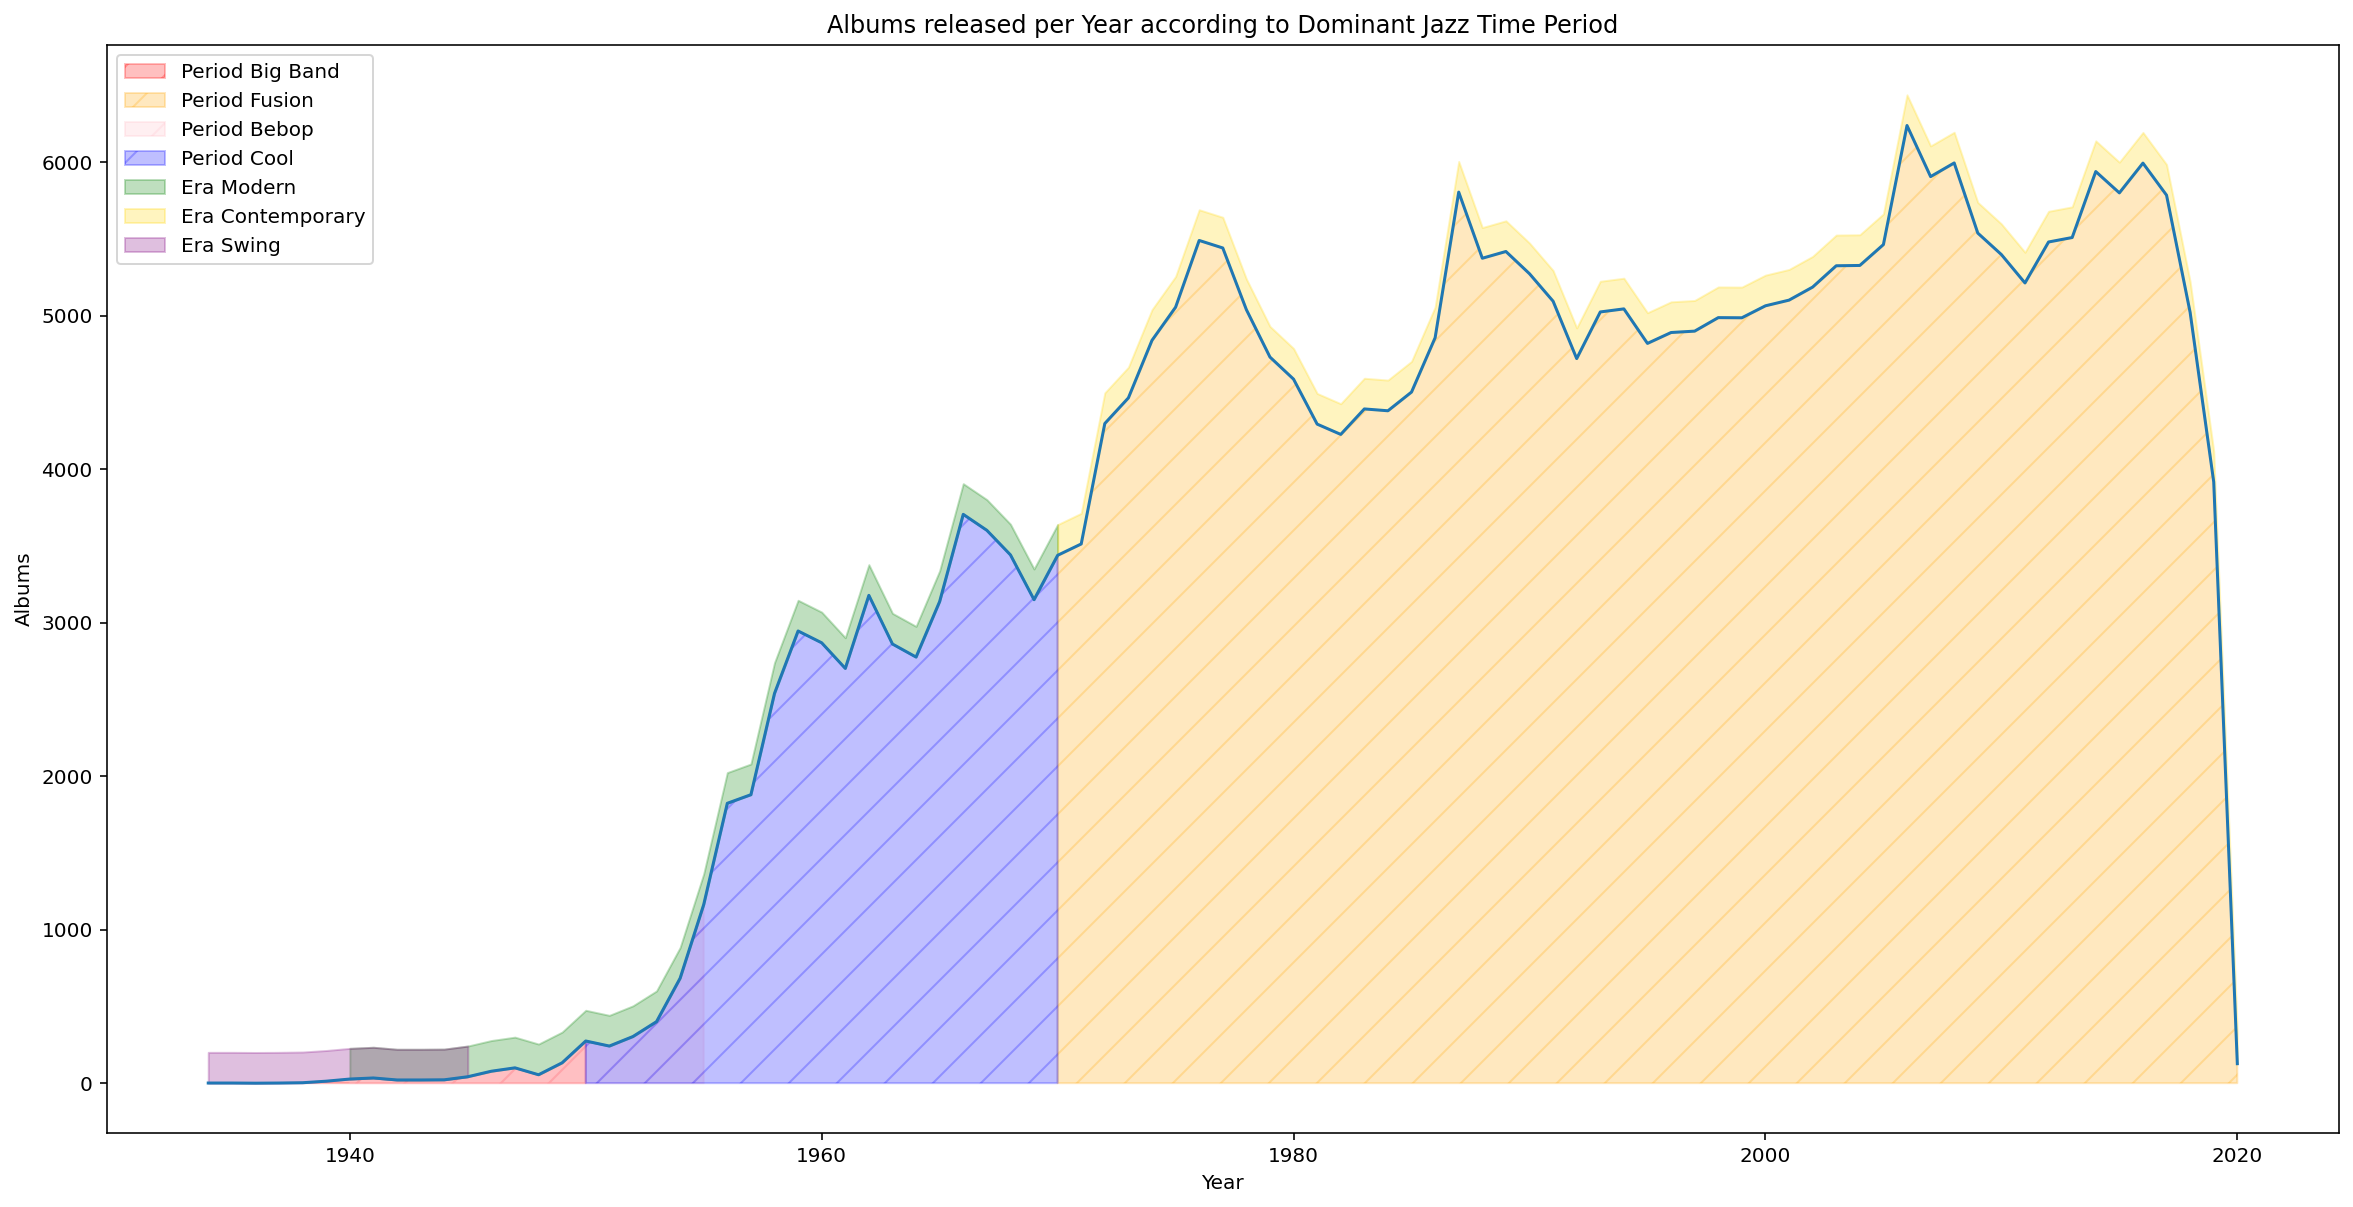

In [ ]:
plot_variable_with_time_periods(year_count_series,time_period_year_range,time_period_colors,xlabel='Year',ylabel='Albums',title='Albums released per Year according to Dominant Jazz Time Period')

As we can see from the above, there was a massive explosion in the number of Jazz albums released per year in the 1950s, with a cyclical rise through the rest of the 20th century and into the 21st. In the Contemporary Jazz Era/Jazz Fusion Period, we see that the number of Jazz Albums released it at its highest, most likely due to the massive influence of Jazz on other genres.

In [ ]:
pure_jazz_album_count = df[df[column_store._genre].sum(axis=1)==0].groupby(by='year').count()['market_value']
pure_jazz_album_count[1934], pure_jazz_album_count[1936] = 0,0
pure_jazz_album_count.sort_index(inplace=True)

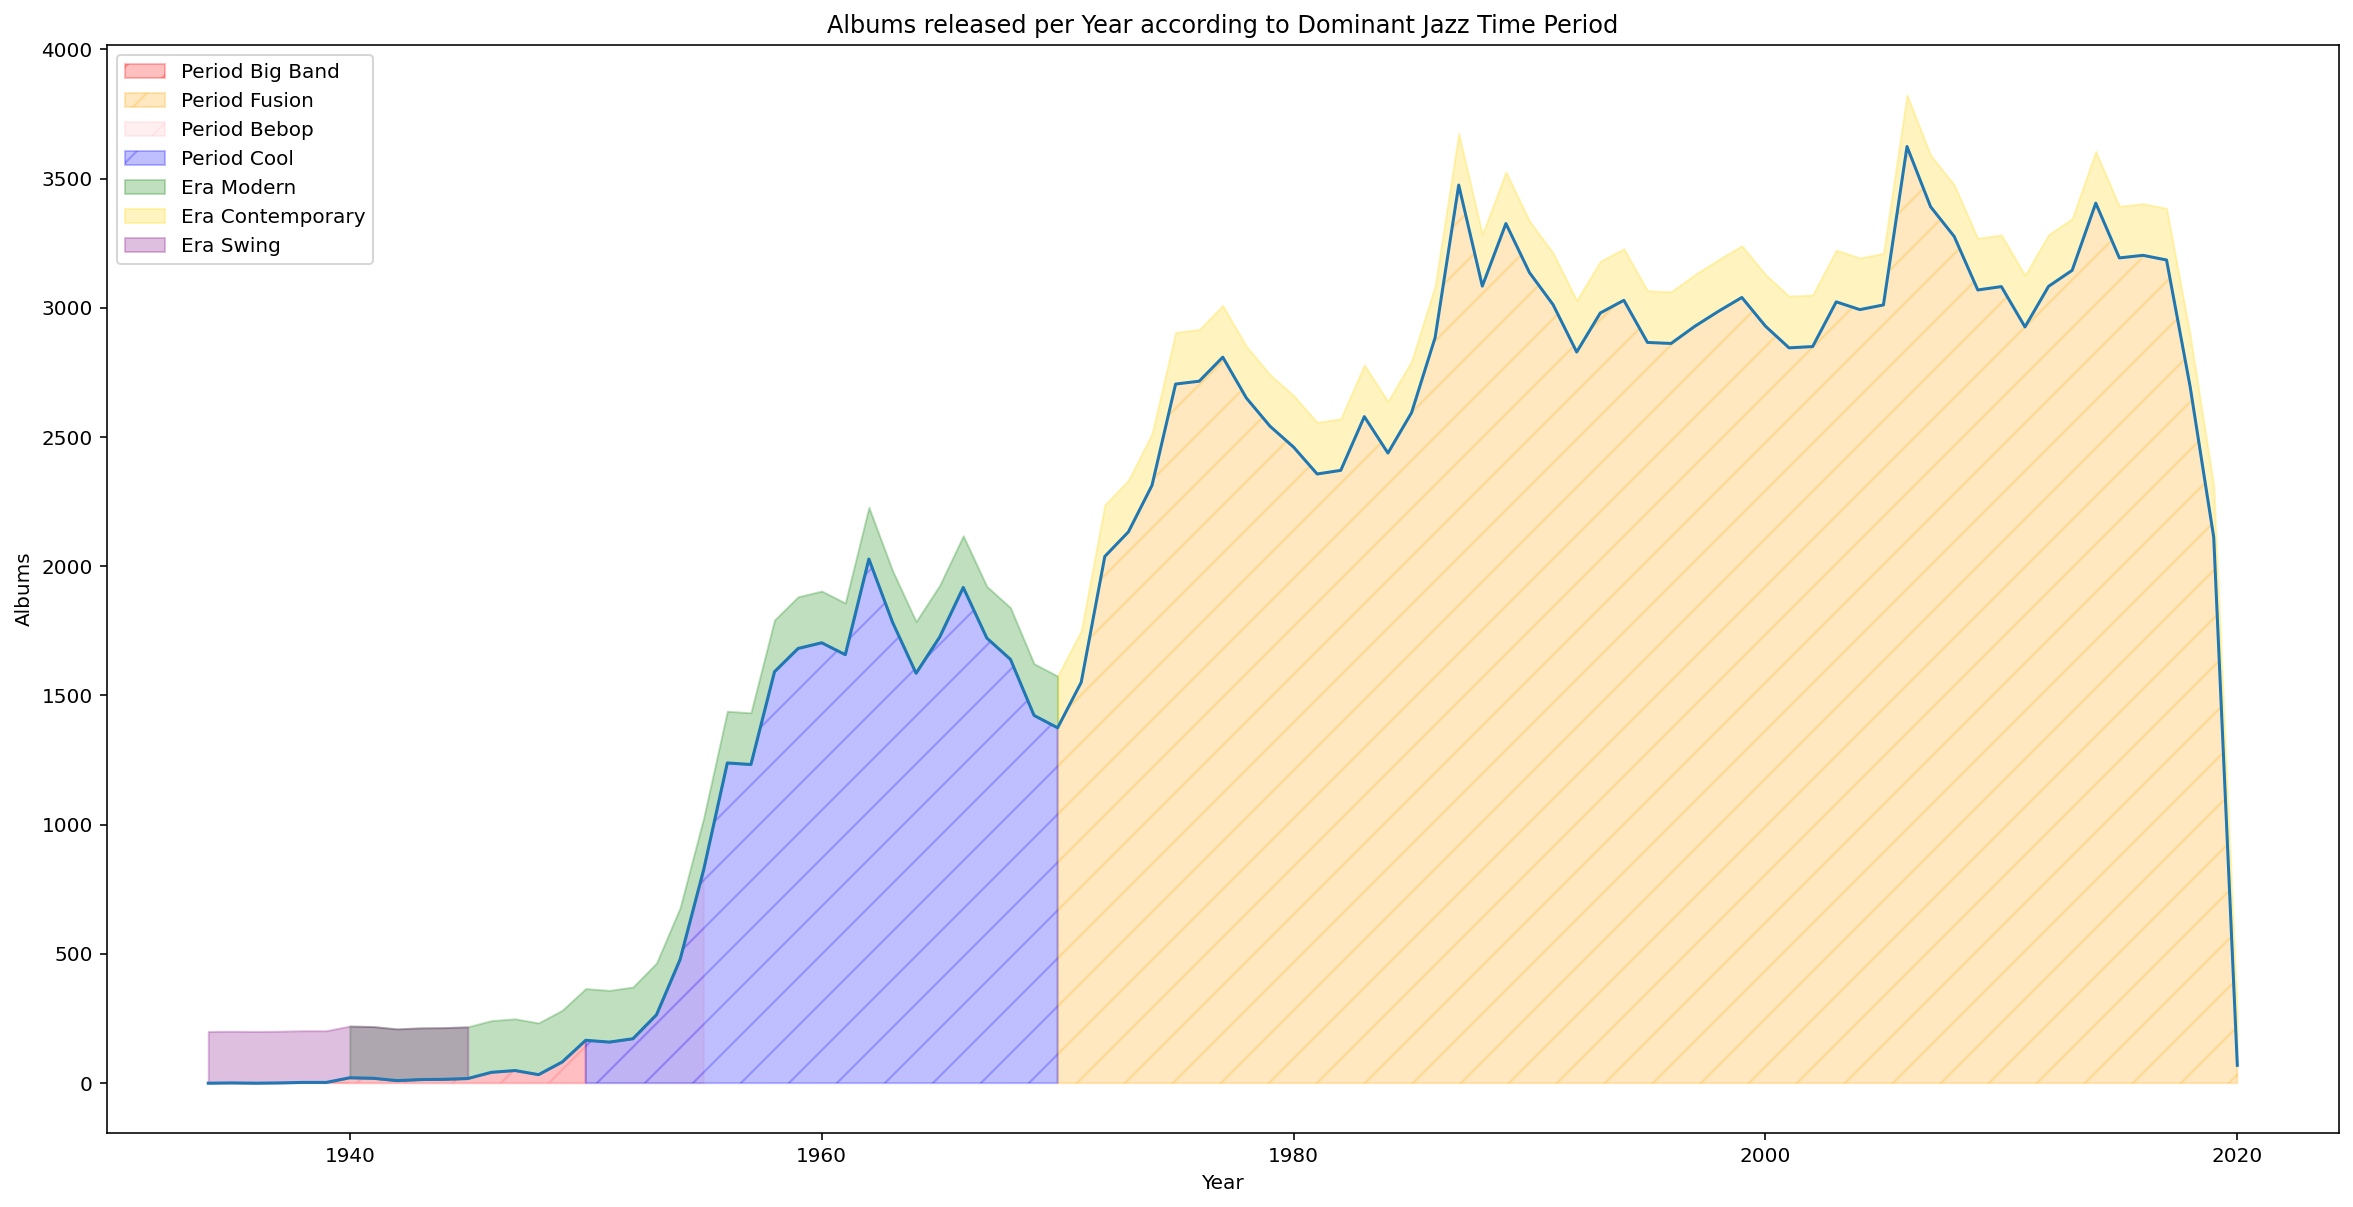

In [ ]:
plot_variable_with_time_periods(pure_jazz_album_count,time_period_year_range,time_period_colors,xlabel='Year',ylabel='Albums',title='Albums released per Year according to Dominant Jazz Time Period')

As we can see, the figure above is effectively identical to the one which includes non 'Pure Jazz' albums, indicating that the rising trend in album releases is not primarily due to the incorporation of Jazz into other styles, but instead a growth of the music in its purest form over time.

## Market Value
### Distribution

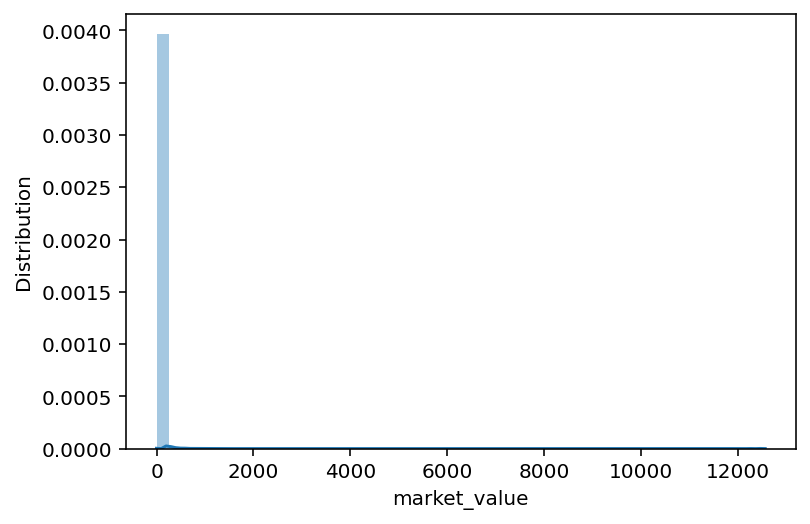

In [ ]:
sns.distplot(df['market_value'])
plt.ylabel('Distribution')
plt.show()

From the above we see that there is a huge left skew for market_value, which means we need to remove outliers

In [ ]:
outlier_remover = OutlierRemover('market_value')
outlier_remover.fit_transform(df)
print('OutlierRemover remover %s rows' % (len(df)-len(outlier_remover.fit_transform(df))))

OutlierRemover remover 1388 rows


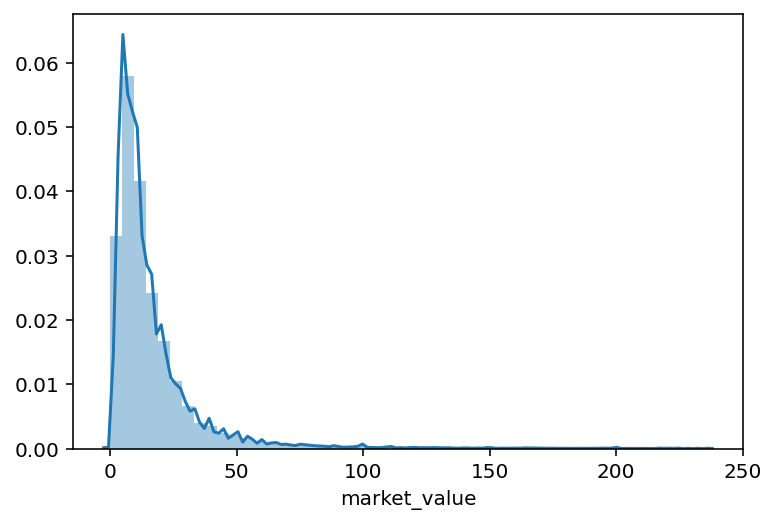

In [ ]:
sns.distplot(outlier_remover.transform(df)['market_value']);

After removing entries with ``market_value`` values exceeding 3 standard deviations from the mean, we see that the distribution has skewed less, making it a prime candidate for log treatment

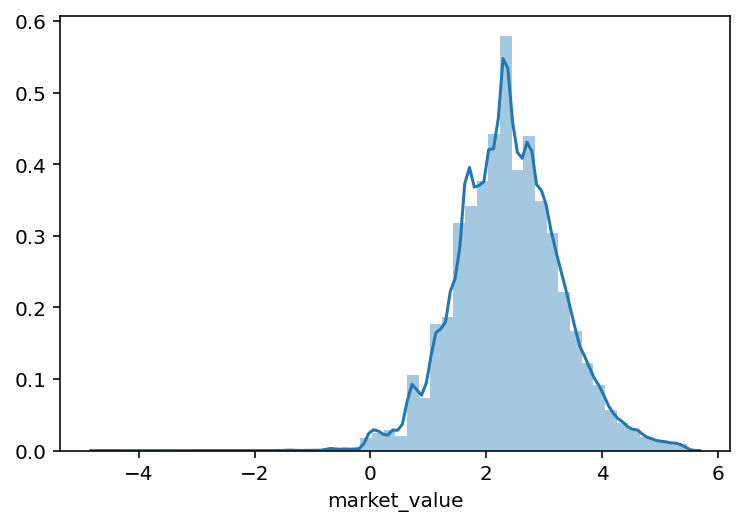

In [ ]:
sns.distplot(np.log(outlier_remover.transform(df)['market_value']));

## Evolution of Market Value over Time

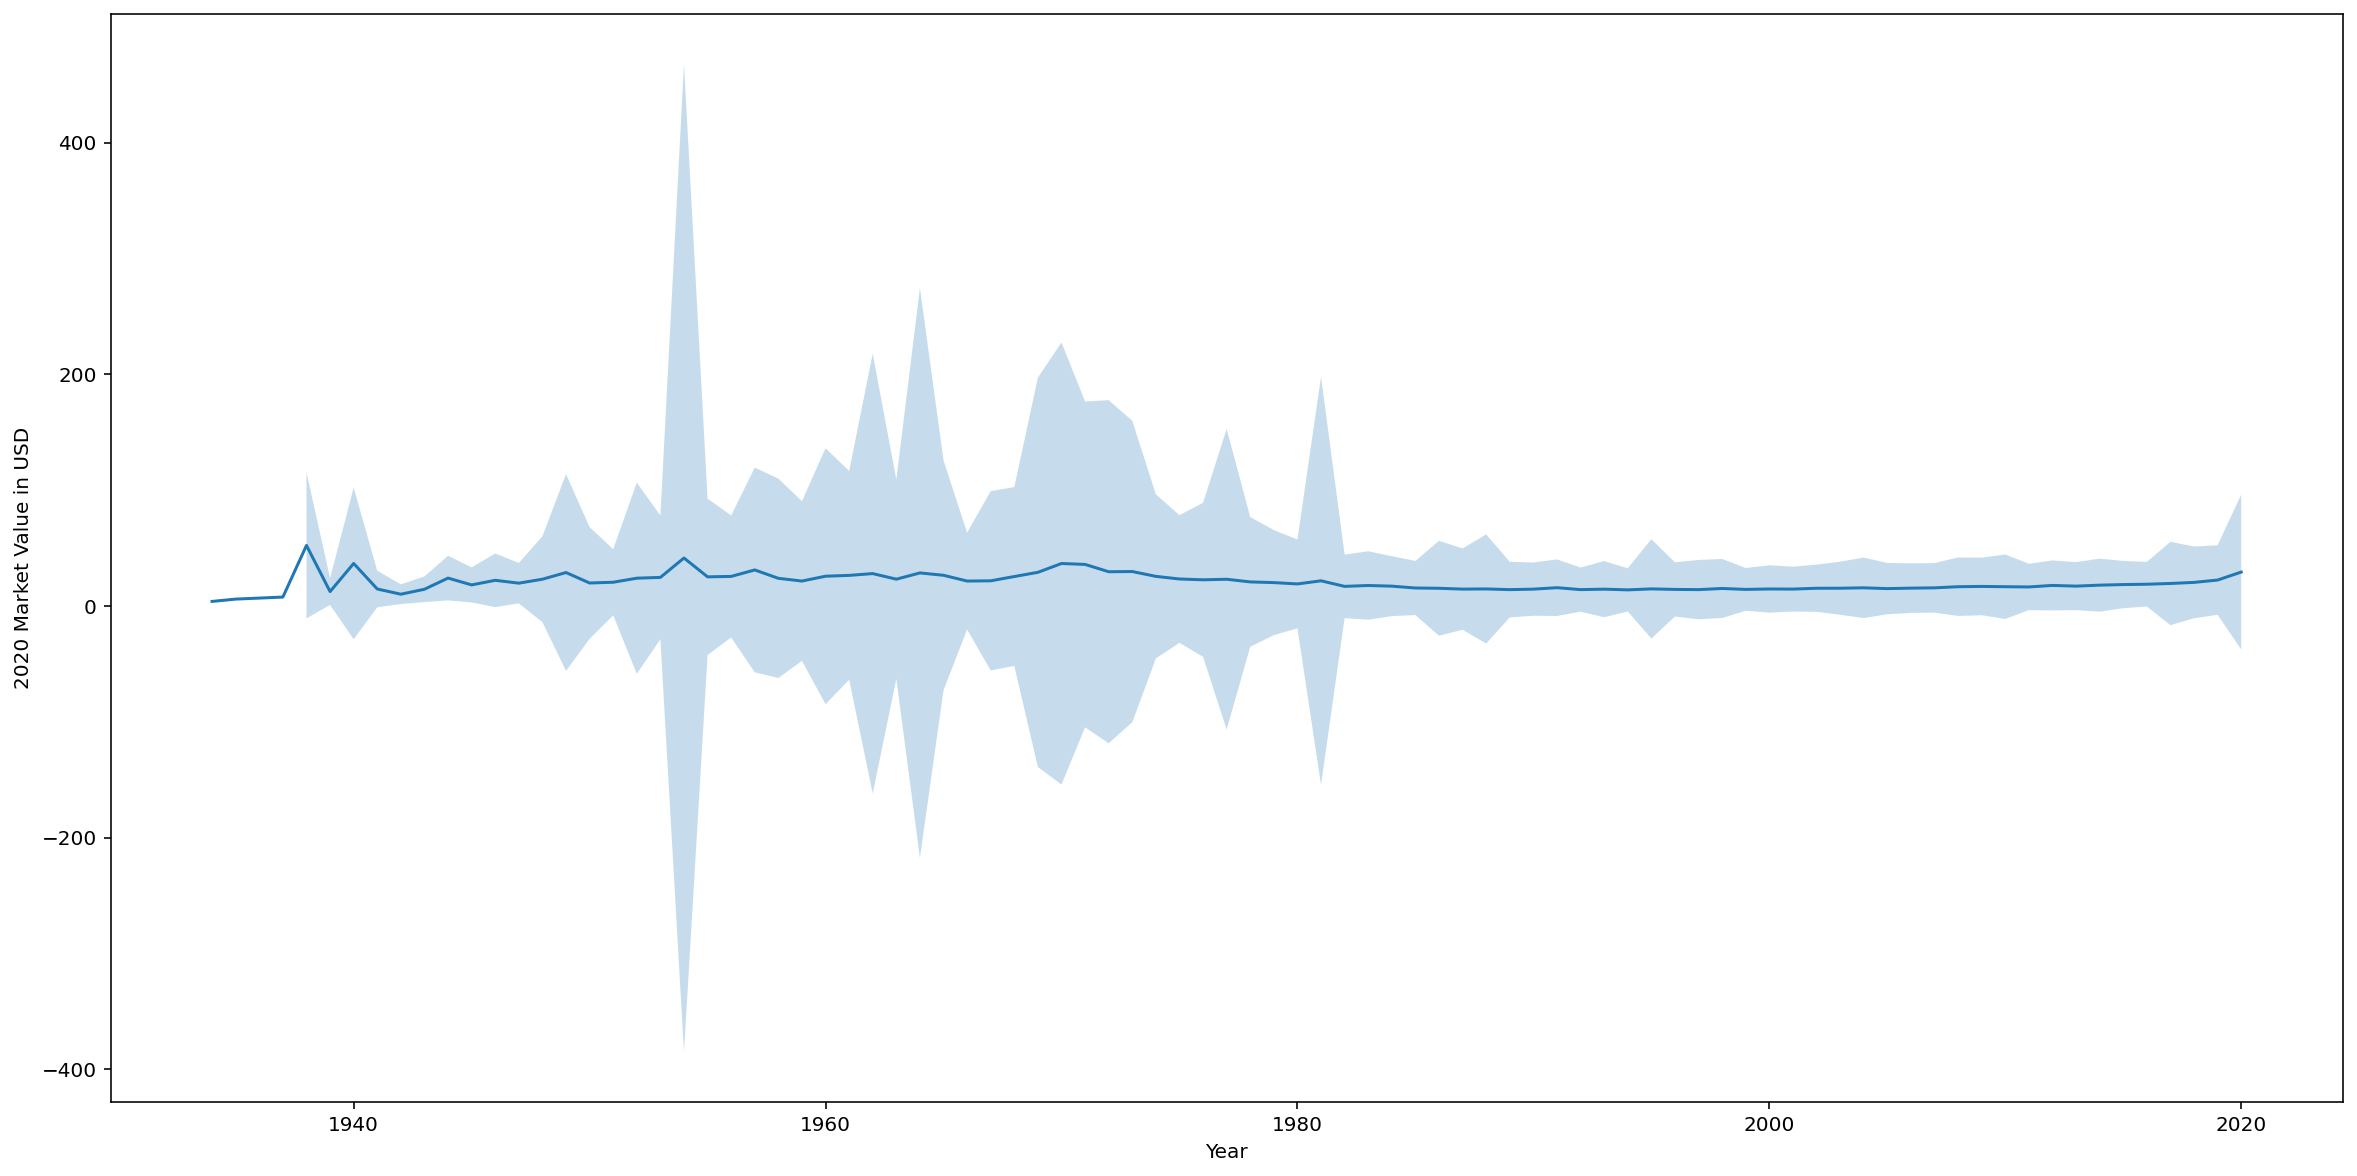

In [ ]:
plt.figure(figsize=(20,10))
plt.xlabel('Year')
plt.ylabel('2020 Market Value in USD')
plt.plot(df.groupby(by='year')['market_value'].mean())
mean_value = df.groupby(by='year')['market_value'].mean()
std_error = df.groupby(by='year')['market_value'].std()
plt.fill_between(std_error.index, mean_value-std_error, mean_value+std_error, alpha=0.25)
plt.show()

From the above, we see that even after removing the most offending outliers, there is still tremendous variation in the price of Jazz records, whic is particularly large in the mid 20th century, and slowly reduces over time, but never to a very small margin

## Correlations 

In [ ]:
pairplot_columns = list(filter(lambda x: df[x].dtype in (float,int) and x not in ['master_id','release_id'],column_store._rest))

In [ ]:
def plot_corr_subplots(df, var, var_list,nrows,ncols,figsize=(60,60)):
    
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)

    for row_idx, row in enumerate(ax):
        for col_idx, col in enumerate(row):
            row_modifier = len(var_list)-ncols*row_idx
            list_idx = len(var_list)-row_modifier+col_idx
            col_column = var_list[list_idx]
            col.set_title(col_column,fontdict={'fontsize':50})
            col.scatter(df[col_column],df[var],edgecolor='white')
    plt.show()

In [ ]:
plot_corr_subplots(df,'market_value',pairplot_columns,4,4)

KeyboardInterrupt: ignored

As we can see from the plots above, there are not many clear relationships that can be identified between the ``market_value`` feature and the numerical features of the dataset. This implies that performance of the model will rely heavily on an efficient encoding of non-numerical data, such as genre, style, artist etc. in order to be able to predict the market value of a given record with any certainty.

In [ ]:
def get_correlation_series(df,correlation_column,columns=None):
    df = df.copy()
    
    if not columns:
        columns = df.columns
    
    return pd.Series({
        column: np.corrcoef(
            df[correlation_column].values,
            df[column].values
        )[0][1]
        for column in columns
    })

In [ ]:
market_value_indicator_correlations = get_correlation_series(df,'market_value',column_store._indicator)

In [ ]:
market_value_indicator_correlations.describe()

From the above, it is clear that the indicator variables are not very highly correlated with ``market_value`` either. As such, we hope that via the leveraging of the multitude of categorical variables, we can improve the result of our price predictions

In [ ]:
sign = market_value_indicator_correlations.apply(lambda x: 'positive' if x >= 0 else 'negative')
market_value_indicator_correlations = pd.DataFrame(
    {'correlation': market_value_indicator_correlations.abs().values,'Sign': sign.values},
    index = market_value_indicator_correlations.index
)

In [ ]:
market_value_indicator_correlations.sort_values(by='correlation',ascending=False).head(25)

As we can see by investigating the top correlations, albums from Japan in particular seem to be the most highly correlated with market value, followed by the formats of Vinyl and CD. Interestingly, there seems to be a positive correlation on price for Vinyl albums, and a negative correlation for CDs, which is what one would generally expect. We also observe that limited edition and reissued albums tend to be priced higher, which also makes sense. An interesting takeaway is that albums from europe and north america tend to be negatively correlated with price, which may be linked to their dominance in the genre and the sheer volume of albums they release. Furthermore, we see that the Hard Bop and Modal jazz styles tend to be the most positively correlated with ``market_value``, which is also understandable, given that these were the dominant styles during the modern jazz era, which defines the genre as a whole.

## Genres

In [ ]:
genre_sum = df[column_store._genre].sum().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(20,10))
plt.xlabel('Additional Genre')
plt.ylabel('# of Albums')
plt.xticks(rotation=30)
plt.bar(genre_sum.index,genre_sum);
plt.show()

In [ ]:
#How many 'pure' jazz albums
pure_jazz_albums = len(df[df[column_store._genre].sum(axis=1)==0])
print('There are {} albums which exclusively list Jazz as a genre, {}% of the dataset'.format(pure_jazz_albums,round(100*pure_jazz_albums/len(df),2)))

## Styles

In [ ]:
style_sum = df[column_store._style].sum()

In [ ]:
style_sum.describe()

In [ ]:
style_sum_top_10 = style_sum[style_sum > style_sum.quantile(0.9)].sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(25,10))
plt.xlabel('Listed Styles')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(style_sum_top_10.index,style_sum_top_10)
plt.show()

As some of the estimators we will use as part of our estimation are sensitive to excessive dimensionality, we will implement a transformer which retains only those indicator variables which are positive for over a certain threshold of entries. This is introduced below as the IndicatorConsolidator transformer.

In [ ]:
style_consolidator = IndicatorConsolidator(columns=column_store._style,output_column='style_Other',threshold=250,counter_name='counter_style')

In [ ]:
df[column_store._style].sum().median()

32.5

In [ ]:
style_consolidator.fit_transform(df)[['style_Other','counter_style']]

style_Other  counter_style
0                 0              2
1                 0              1
2                 0              2
3                 0              1
4                 0              2
...             ...            ...
297541            0              2
297542            0              1
297543            0              1
297544            0              3
297545            0              2

[297546 rows x 2 columns]

## Format Description

In [ ]:
format_description_sum = df[column_store._format_description].sum().sort_values(ascending=False)
format_description_sum.describe()

count       115.000000
mean       5559.973913
std       31050.794168
min           0.000000
25%           1.000000
50%          20.000000
75%         433.500000
max      296139.000000
dtype: float64

In [ ]:
format_description_sum.iloc[:25]

format_description_Album                 296139
format_description_LP                    137992
format_description_Reissue                61536
format_description_Stereo                 35943
format_description_Remastered             24471
format_description_Mono                   23929
format_description_Limited Edition        16609
format_description_Promo                  11135
format_description_Compilation             6299
format_description_Club Edition            3239
format_description_Repress                 3095
format_description_10"                     2770
format_description_Numbered                1624
format_description_45 RPM                  1085
format_description_Test Pressing            882
format_description_Mini-Album               852
format_description_Enhanced                 851
format_description_12"                      774
format_description_Hybrid                   753
format_description_Quadraphonic             670
format_description_7"                   

In [ ]:
description_consolidator = IndicatorConsolidator(columns=column_store._format_description,output_column='format_description_Other',threshold=None,counter_name='counter_format_description')

In [ ]:
description_consolidator.fit_transform(df)

release_id  ...  format_description_Other
0         10550056  ...                         0
1          6910984  ...                         0
2          8592628  ...                         0
3          8684706  ...                         0
4          8049748  ...                         0
...            ...  ...                       ...
297541     7340022  ...                         0
297542    12058618  ...                         0
297543    11534331  ...                         0
297544     1572860  ...                         0
297545    11010045  ...                         0

[297546 rows x 821 columns]

## Format Text

In [ ]:
format_name_sum = pd.get_dummies(df['format_name']).sum().sort_values(ascending=False)
format_name_sum.describe()

count        29.000000
mean      10260.206897
std       36119.742238
min           1.000000
25%           4.000000
50%          33.000000
75%         397.000000
max      141050.000000
dtype: float64

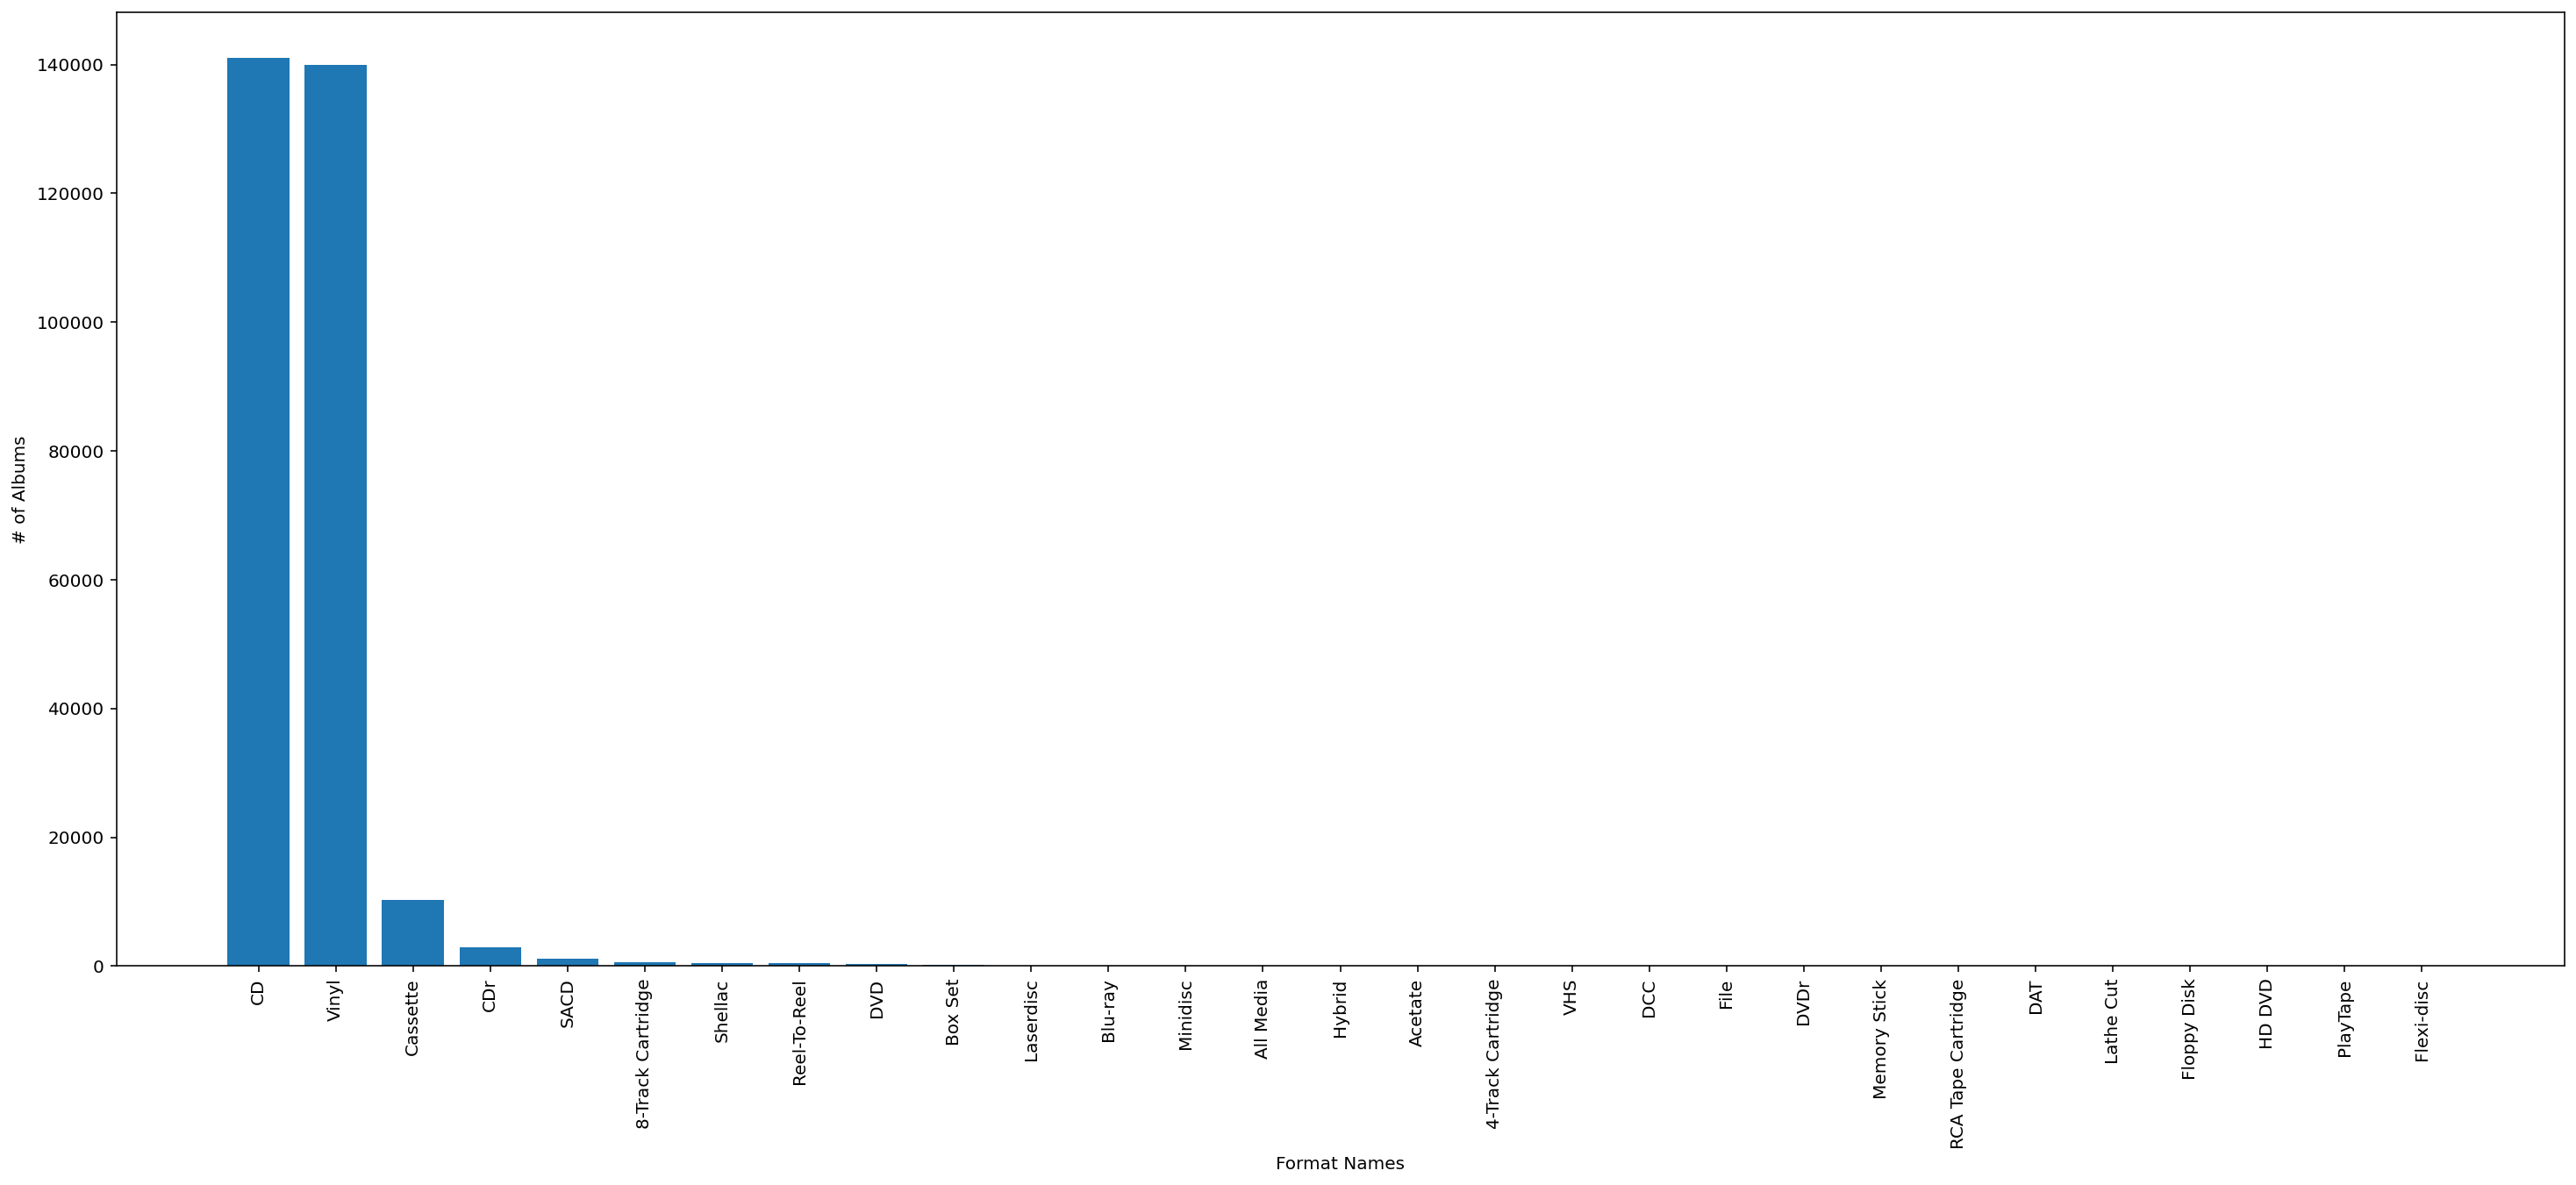

In [ ]:
plt.figure(figsize=(25,10))
plt.xlabel('Format Names')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(format_name_sum.index,format_name_sum)
plt.show()

From the above, we can see that it would be wise to reduce the ``format_name`` indicator variable dimensionality, as there are really three non-trivially large format categories, namely ``CD``, ``Vinyl`` and ``Cassette``. The rest we will combine into an ``Other`` indicator. We will also combine ``CD`` and ``CDr``, as these formats are essentially equivalent

In [ ]:
format_name_consolidator = IndicatorConsolidator(output_column='format_name_other',threshold=5000)
format_name_consolidator.fit_transform(pd.get_dummies(df['format_name']))

CD  Cassette  Vinyl  format_name_other
0        0         0      0                  1
1        0         0      0                  1
2        0         0      0                  1
3        0         0      0                  1
4        0         0      0                  1
...     ..       ...    ...                ...
297541   0         0      1                  0
297542   1         0      0                  0
297543   1         0      0                  0
297544   0         0      1                  0
297545   0         0      1                  0

[297546 rows x 4 columns]

## Mapping Most Albums

In [ ]:
map_df = gpd.read_file(os.path.join(DATA_PATH,'countries/ne_110m_admin_0_countries.shp'))

DriverError: ignored

In [ ]:
visualization_countries = list(filter(lambda x: x not in ['country_yugoslavia','country_ussr','country_taiwan'],column_store._geography_country))
country_album_count = df[visualization_countries].sum()

In [ ]:
'Unknown' in df['country'].unique()

In [ ]:
def assign_country_codes(country):
    try:
        return COUNTRY_CODES[country.split('_')[-1]]
    except KeyError as e:
        print(country)
        return '000'

In [ ]:
country_codes = pd.Series(tuple(map(assign_country_codes,visualization_countries)),index=visualization_countries)

In [ ]:
country_df = pd.DataFrame(country_album_count)

In [ ]:
country_df['codes'] = country_codes

In [ ]:
country_df['ISO_A3'] = country_df.loc[:,'codes'].map(M49_TO_ISO3) 

In [ ]:
country_df.sort_values(0,ascending=False)

0 codes ISO_A3
country_united states of america                    92920.0   840    USA
country_japan                                       40166.0   392    JPN
country_united kingdom of great britain and nor...  23553.0   826    GBR
country_germany                                     23490.0   276    DEU
country_france                                      14711.0   250    FRA
...                                                     ...   ...    ...
country_namibia                                         0.0   516    NAM
country_cameroon                                        0.0   120    CMR
country_eswatini [swaziland]                            0.0   748    SWZ
country_bangladesh                                      0.0   050    BGD
country_jordan                                          0.0   400    JOR

[152 rows x 3 columns]

In [ ]:
merge = map_df.set_index('ISO_A3').join(country_df.set_index('ISO_A3'))

In [ ]:
merge.fillna(0,inplace=True)

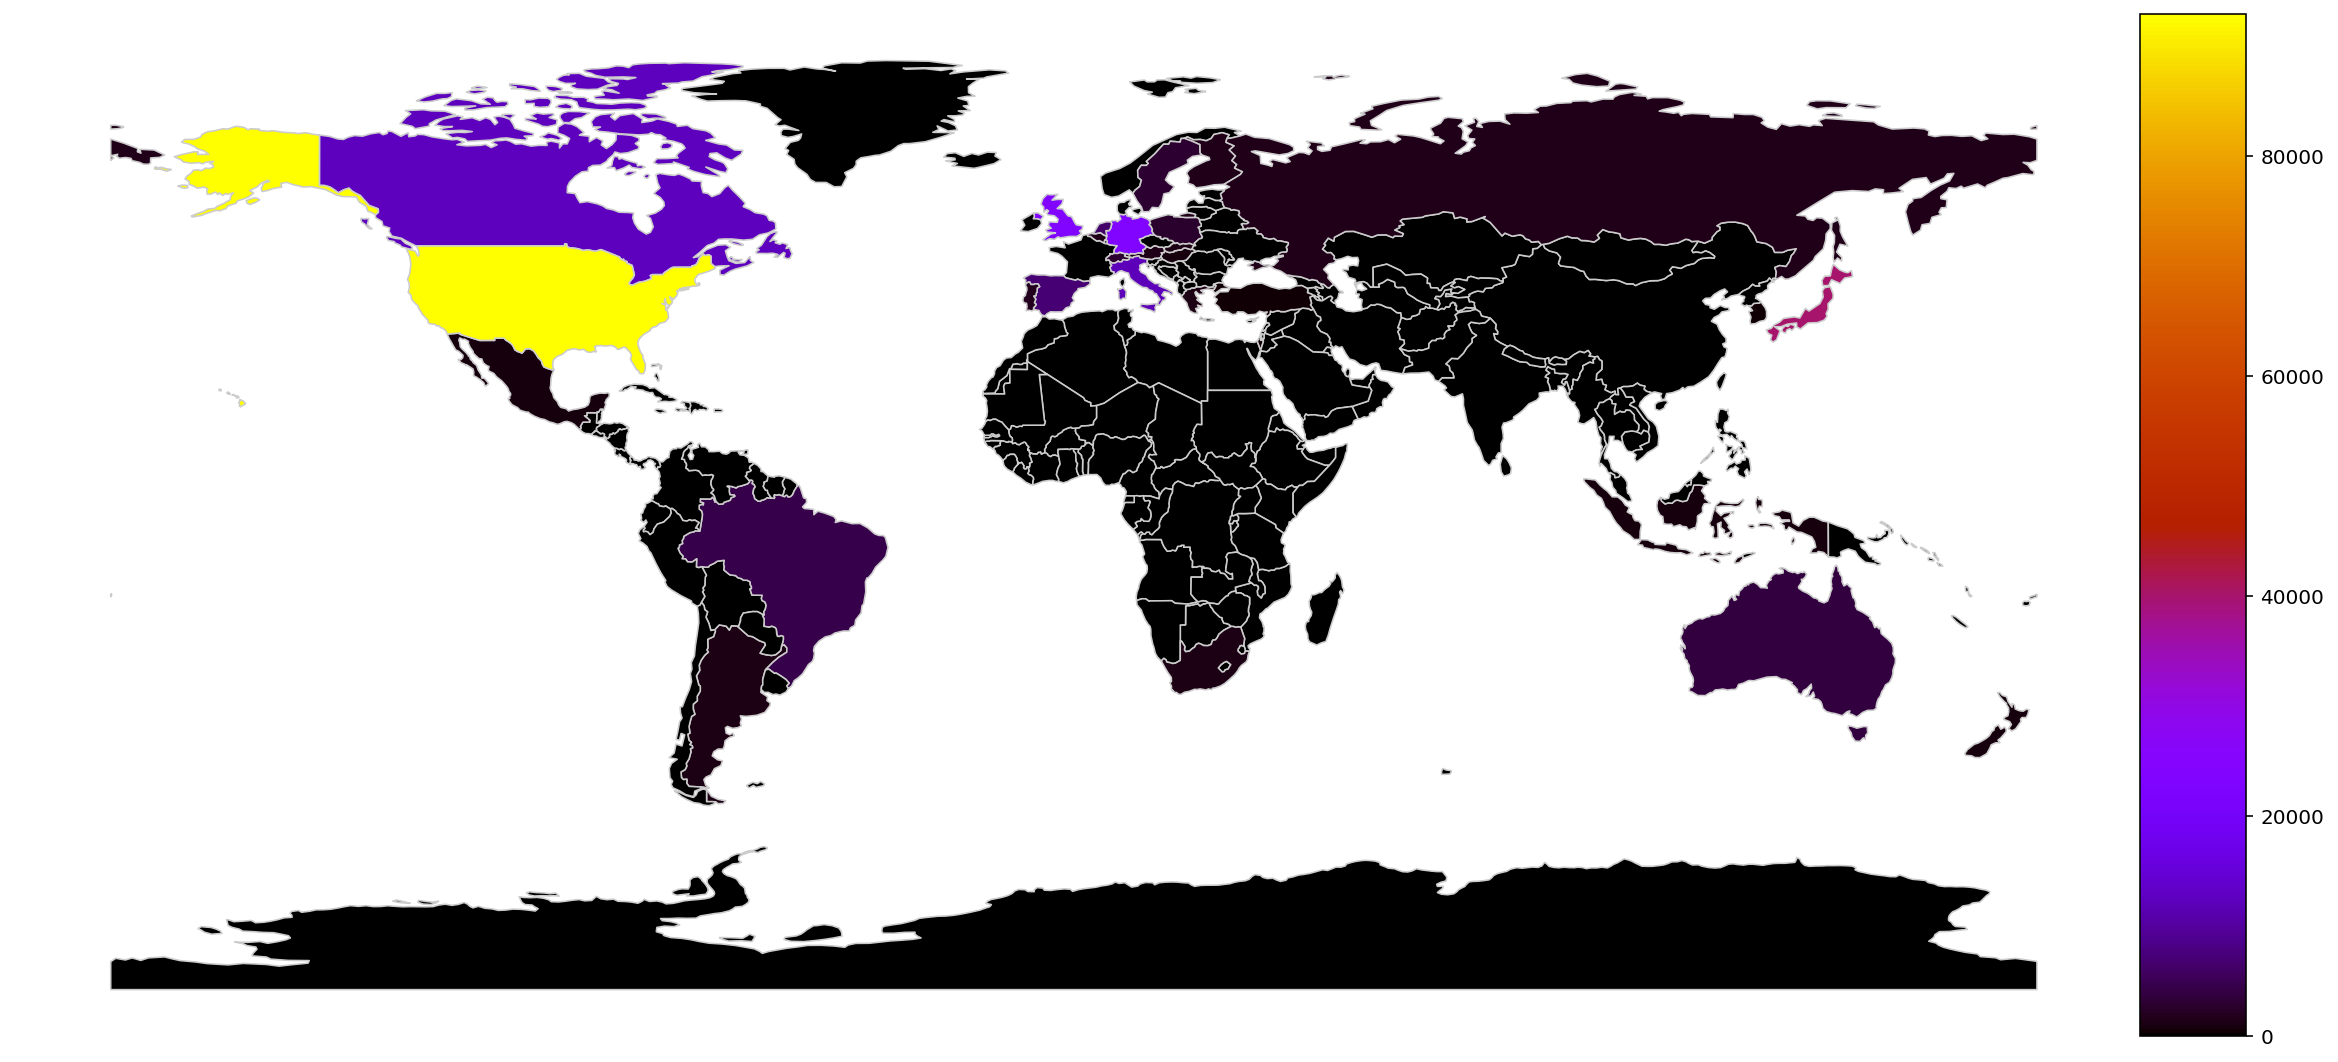

In [ ]:
vmin, vmax = min(merge[0]),max(merge[0])
fig, ax = plt.subplots(1,figsize=(20,20))
merge.plot(column=0,cmap='gnuplot',linewidth=0.8,ax=ax,edgecolor='0.8')
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='gnuplot',norm=plt.Normalize(vmin=vmin,vmax=vmax))
sm._a = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sm,cax=cax)
plt.show()

# High Level Features
## Loading and Cleaning

In [ ]:
with np.load(os.path.join(DATA_PATH,'high_level_features_labelled.npz')) as data:
    image_embedding_df = pd.concat([pd.DataFrame(data[section]) for section in ('release_id','bitmap','features')],axis=1)
    image_embedding_df.columns = ['release_id', 'bitmap'] + ['feature_%s' % i for i in range(1,1281)]

In [ ]:
df = df.merge(image_embedding_df,on='release_id',how='inner')

In [ ]:
del image_embedding_df

In [12]:
col_set['image_embedding'] = 'feature_'
column_store = ColumnStore()
column_store.fit(df,col_set)

In [ ]:
from cuml import UMAP

In [ ]:
scaler = StandardScaler()
image_embeddings_scaled = scaler.fit_transform(df.loc[:,sorted(list(column_store._image_embedding))])

In [ ]:
#Defining PCA and UMAP transformers
pca_2d = PCA(n_components=2)
umap_2d = UMAP(n_components=2)

In [16]:
pca_2d_output = pca_2d.fit_transform(image_embeddings_scaled)
umap_2d_output = umap_2d.fit_transform(image_embeddings_scaled)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [ ]:
for embedding in ('pca_2d','umap_2d'):
  col_set[embedding] = ''.join([embedding,'_'])

In [ ]:
df = pd.concat(
    [df,
     pd.DataFrame(pca_2d_output,columns=('pca_2d_0','pca_2d_1')),
     pd.DataFrame(umap_2d_output,columns=('umap_2d_0','umap_2d_1')),
    ],
    axis=1)

In [19]:
column_store.fit(df,col_set)

In [ ]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

In [ ]:
def plot_indicator_2d(df, columns,embedding_columns=None,**kwargs):
    df = df.copy()
    if not embedding_columns:
        embedding_columns = list(filter(lambda x: 'embedding_2d' in x,df.columns))
    cmap = get_cmap(len(columns))
    plt.figure(figsize=(10,10))
    
    if kwargs.get('colors'):
        colors = kwargs.get('colors')
    else:
        cmap = get_cmap(len(columns))
        colors = [cmap(index) for index in range(len(columns))]  
    
    for index,column in enumerate(columns):
        column_embedding = df[df[column]==1][embedding_columns]
        plt.scatter(
            column_embedding.iloc[:,0],
            column_embedding.iloc[:,1],
            label=column.split('_')[-1],
            color=colors[index],
            alpha=0.25,
            edgecolor='white'
        )
    
    plt.legend()

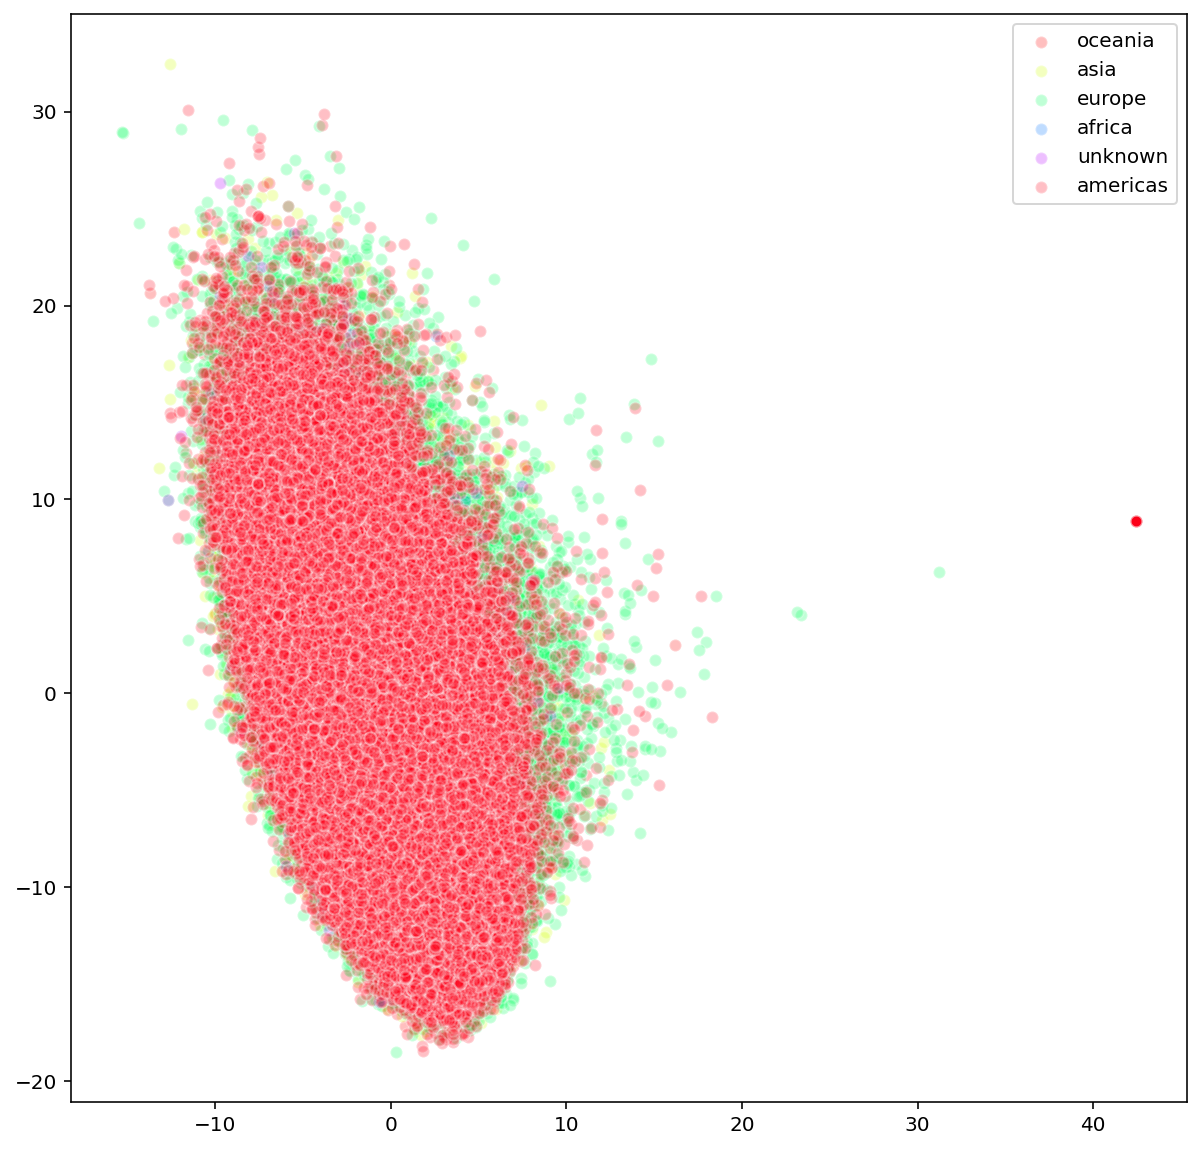

In [23]:
plot_indicator_2d(df,column_store._geography_superregion,column_store._pca_2d)

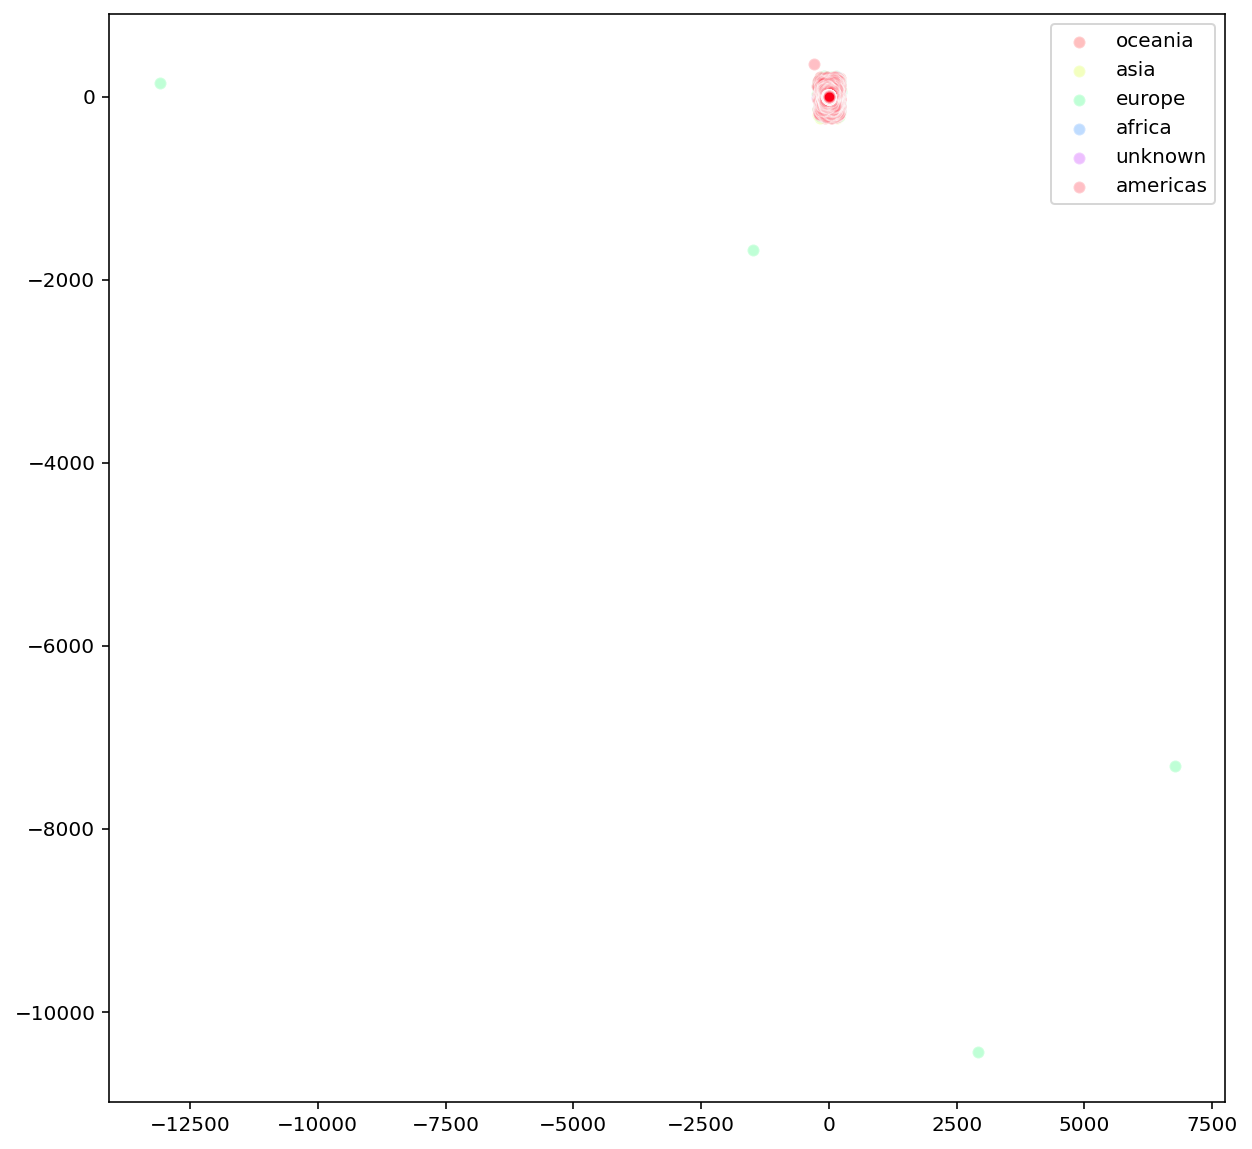

In [27]:
plot_indicator_2d(df,column_store._geography_superregion,column_store._umap_2d)

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


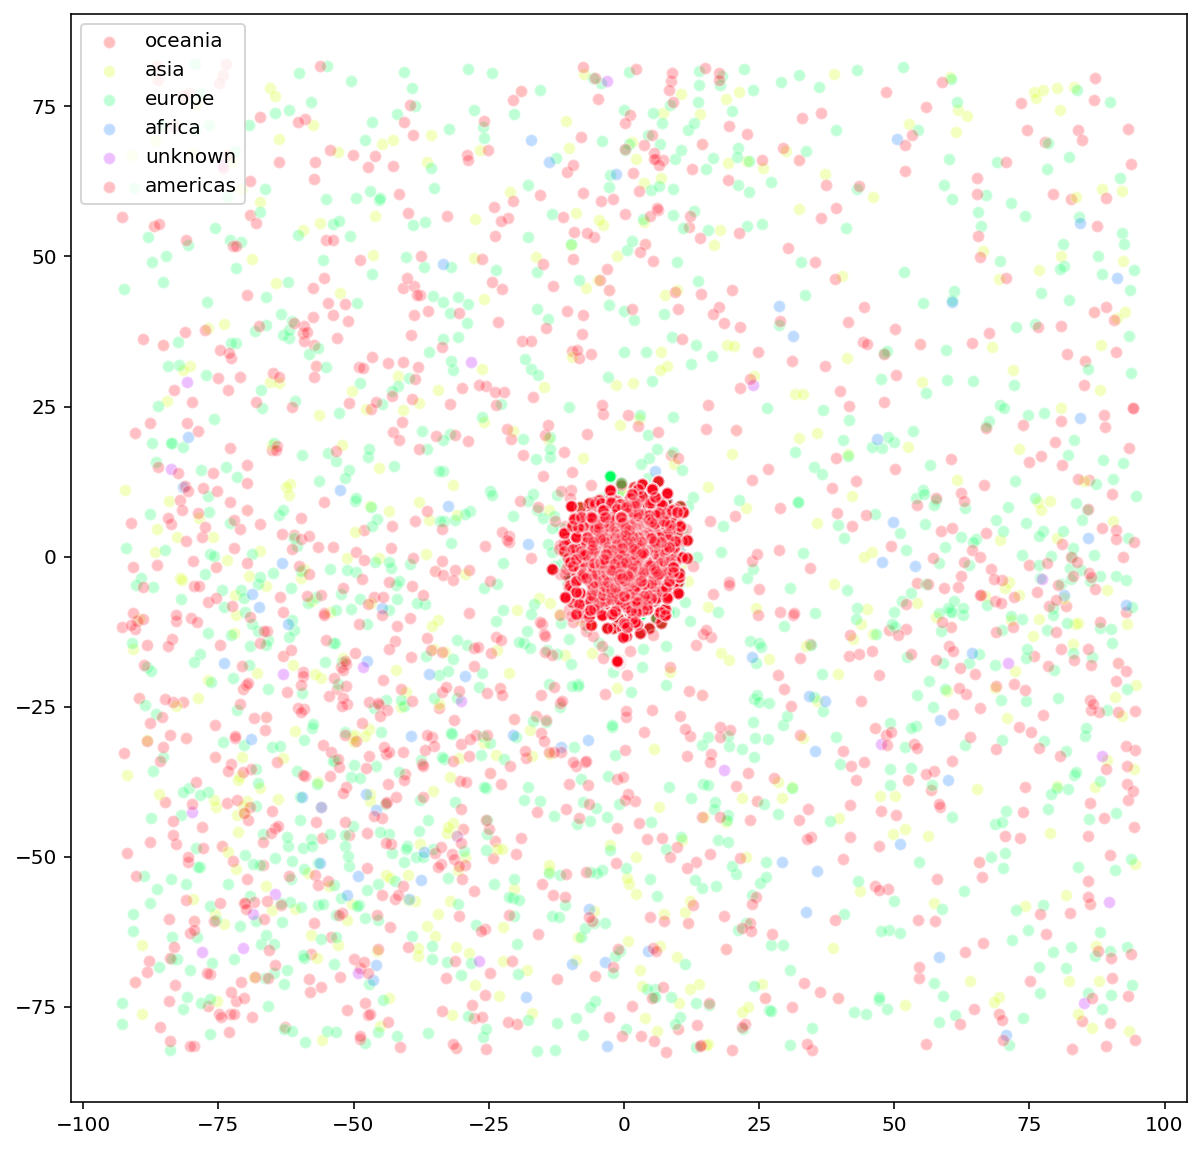

In [26]:
outlier_remover = OutlierRemover(features=column_store._umap_2d)
plot_indicator_2d(outlier_remover.fit_transform(df),column_store._geography_superregion,column_store._umap_2d)

In [29]:
df['market_value'].quantile([0.25,0.5,0.75,1])

0.25        6.000000
0.50       10.891478
0.75       19.604661
1.00    12567.088784
Name: market_value, dtype: float64

In [ ]:
def identify_quantile(x,lower,upper):
    if x >= lower and x <= upper:
        return 1
    return 0

In [ ]:
for quantile in [0.25,0.5,0.75,1]:
    df['market_value_quantile_%s' % quantile] = df['market_value'].apply(identify_quantile,lower=df['market_value'].quantile(quantile-0.25),upper=df['market_value'].quantile(quantile))

In [35]:
market_value_quantiles = list(filter(lambda x: 'market_value_quantile' in x,df.columns))
df[market_value_quantiles].describe()

market_value_quantile_0.25  ...  market_value_quantile_1
count               297356.000000  ...            297356.000000
mean                     0.253151  ...                 0.251197
std                      0.434818  ...                 0.433702
min                      0.000000  ...                 0.000000
25%                      0.000000  ...                 0.000000
50%                      0.000000  ...                 0.000000
75%                      1.000000  ...                 1.000000
max                      1.000000  ...                 1.000000

[8 rows x 4 columns]

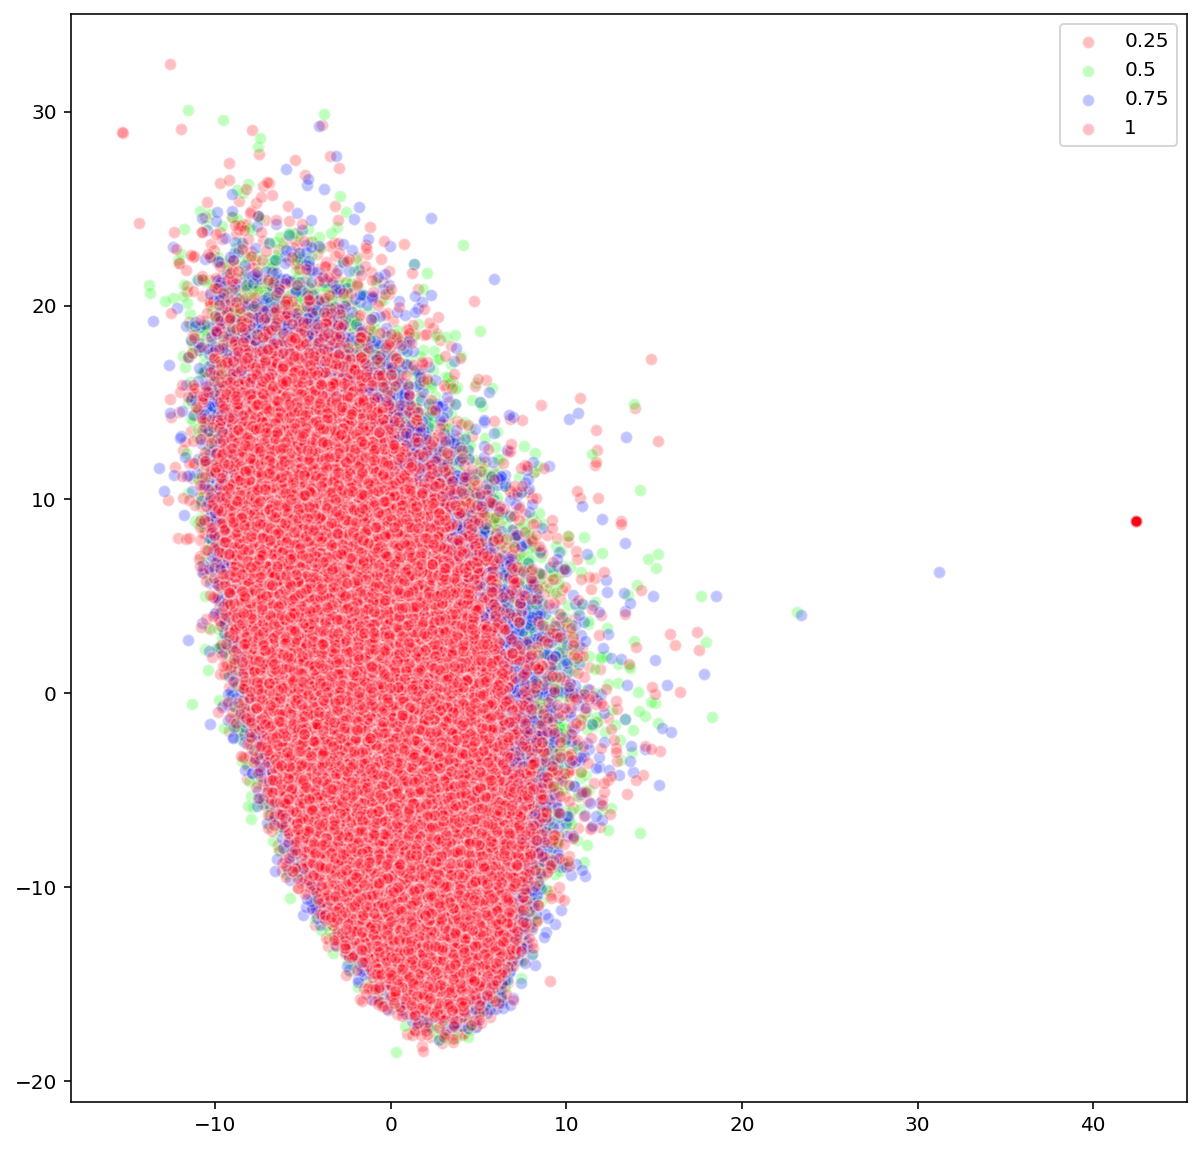

In [38]:
plot_indicator_2d(df,market_value_quantiles,column_store._pca_2d)

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


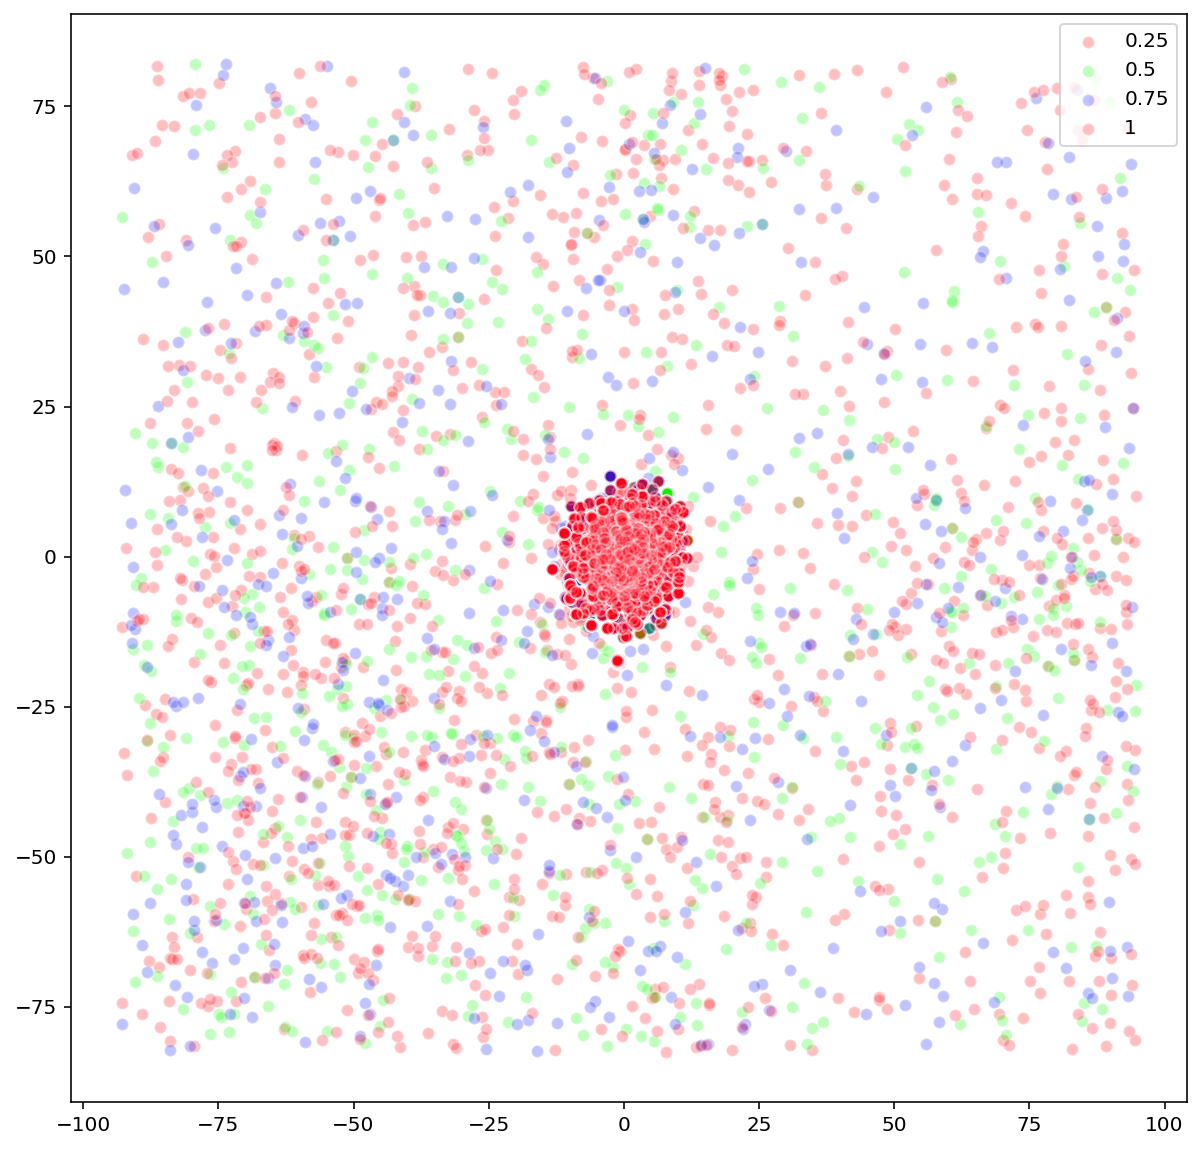

In [39]:
plot_indicator_2d(outlier_remover.fit_transform(df),market_value_quantiles,column_store._umap_2d)

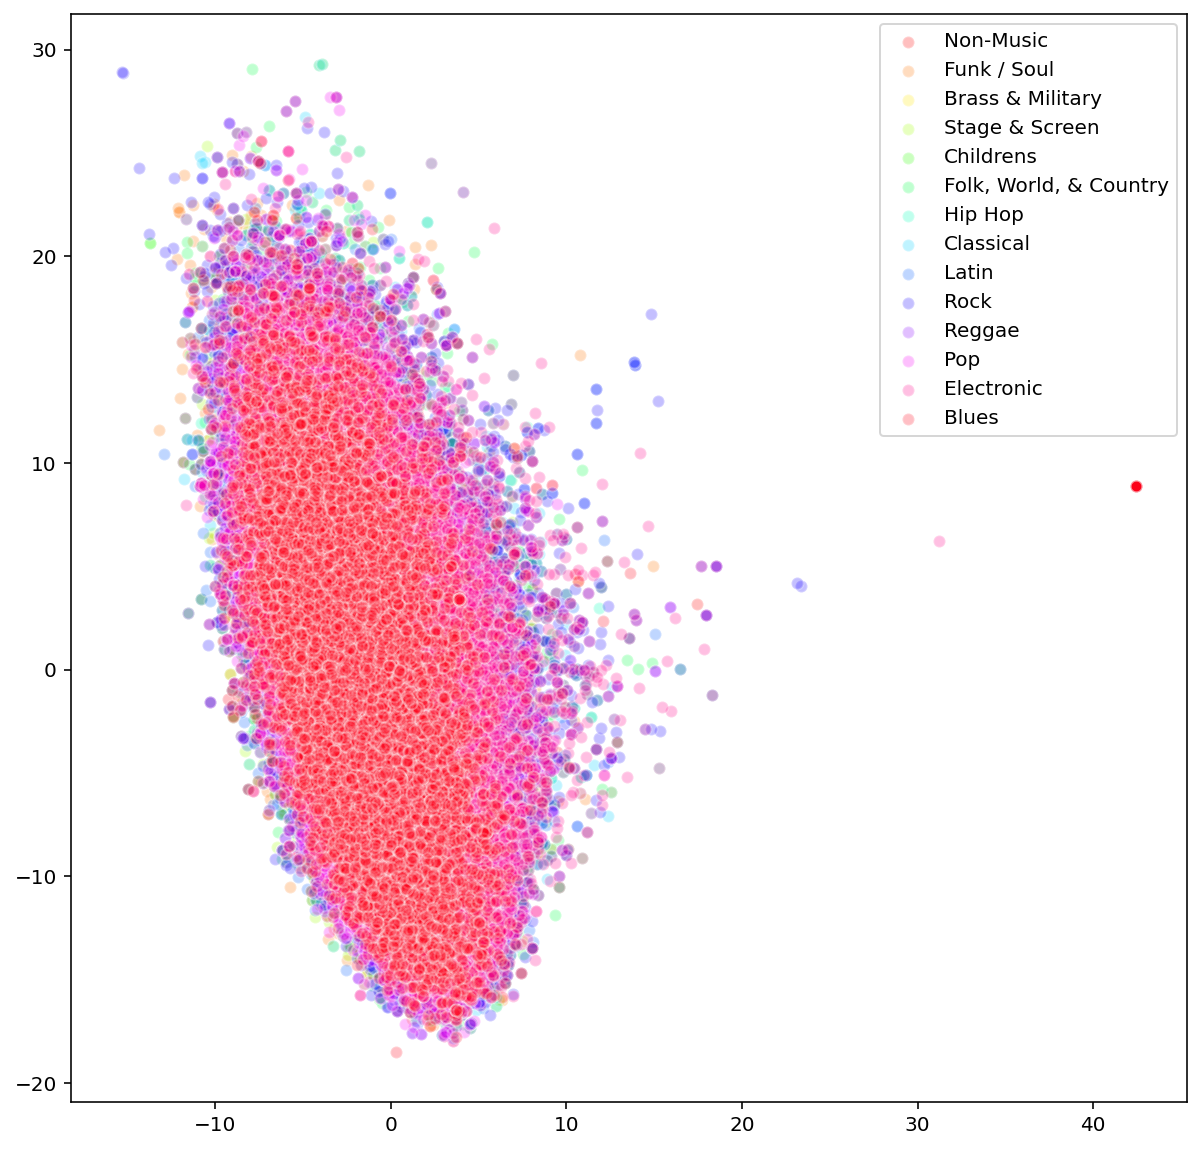

In [40]:
plot_indicator_2d(df,column_store._genre,column_store._pca_2d)

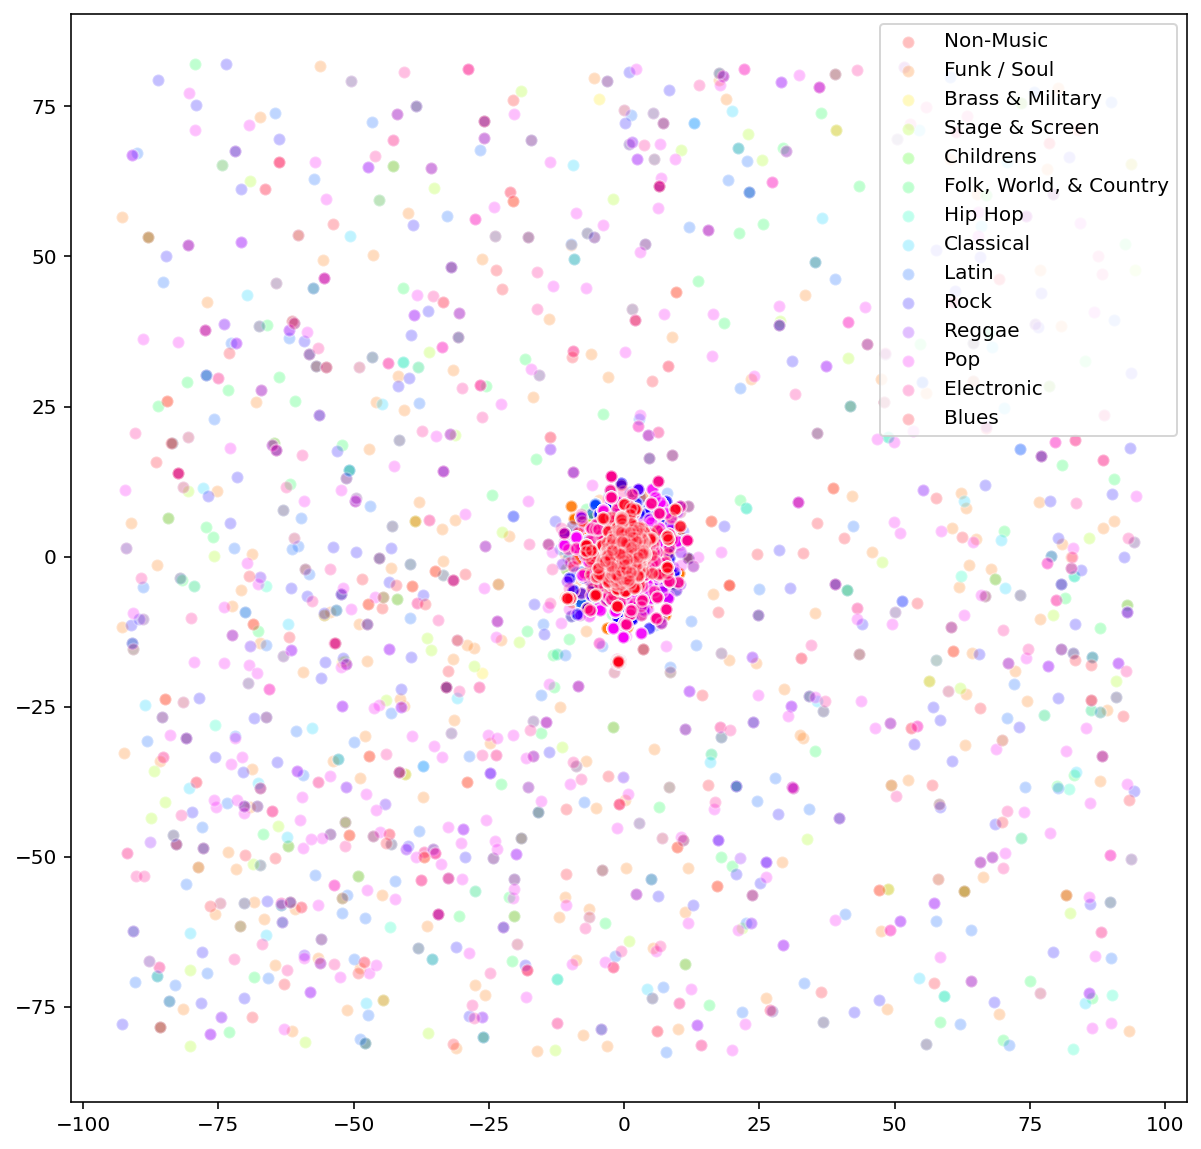

In [42]:
plot_indicator_2d(outlier_remover.fit_transform(df),column_store._genre,column_store._umap_2d)

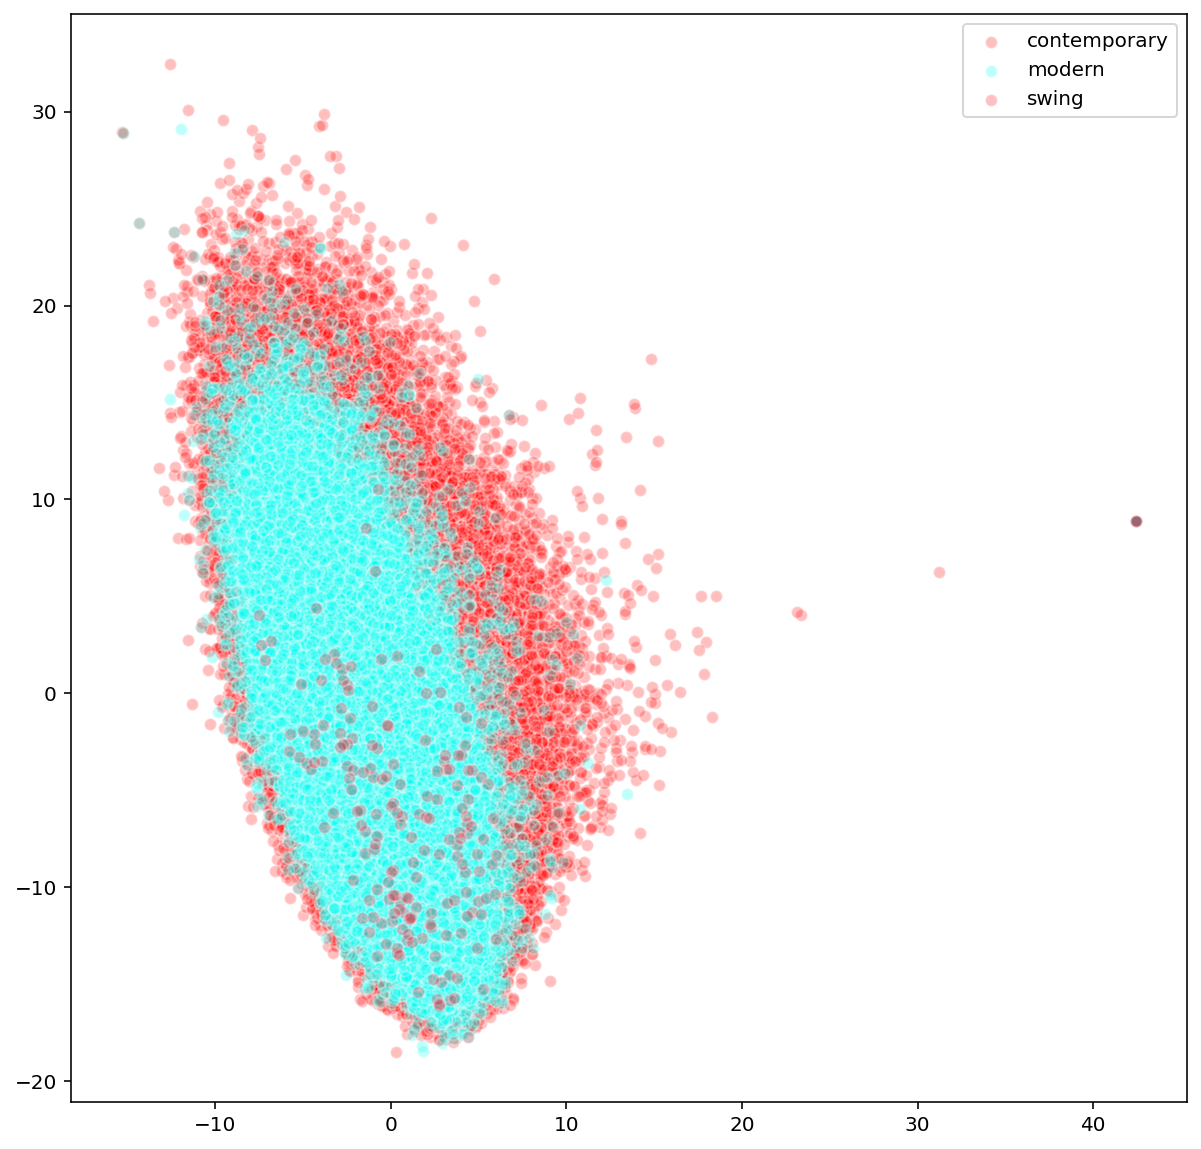

In [44]:
plot_indicator_2d(df,column_store._timeperiod_era,column_store._pca_2d)

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


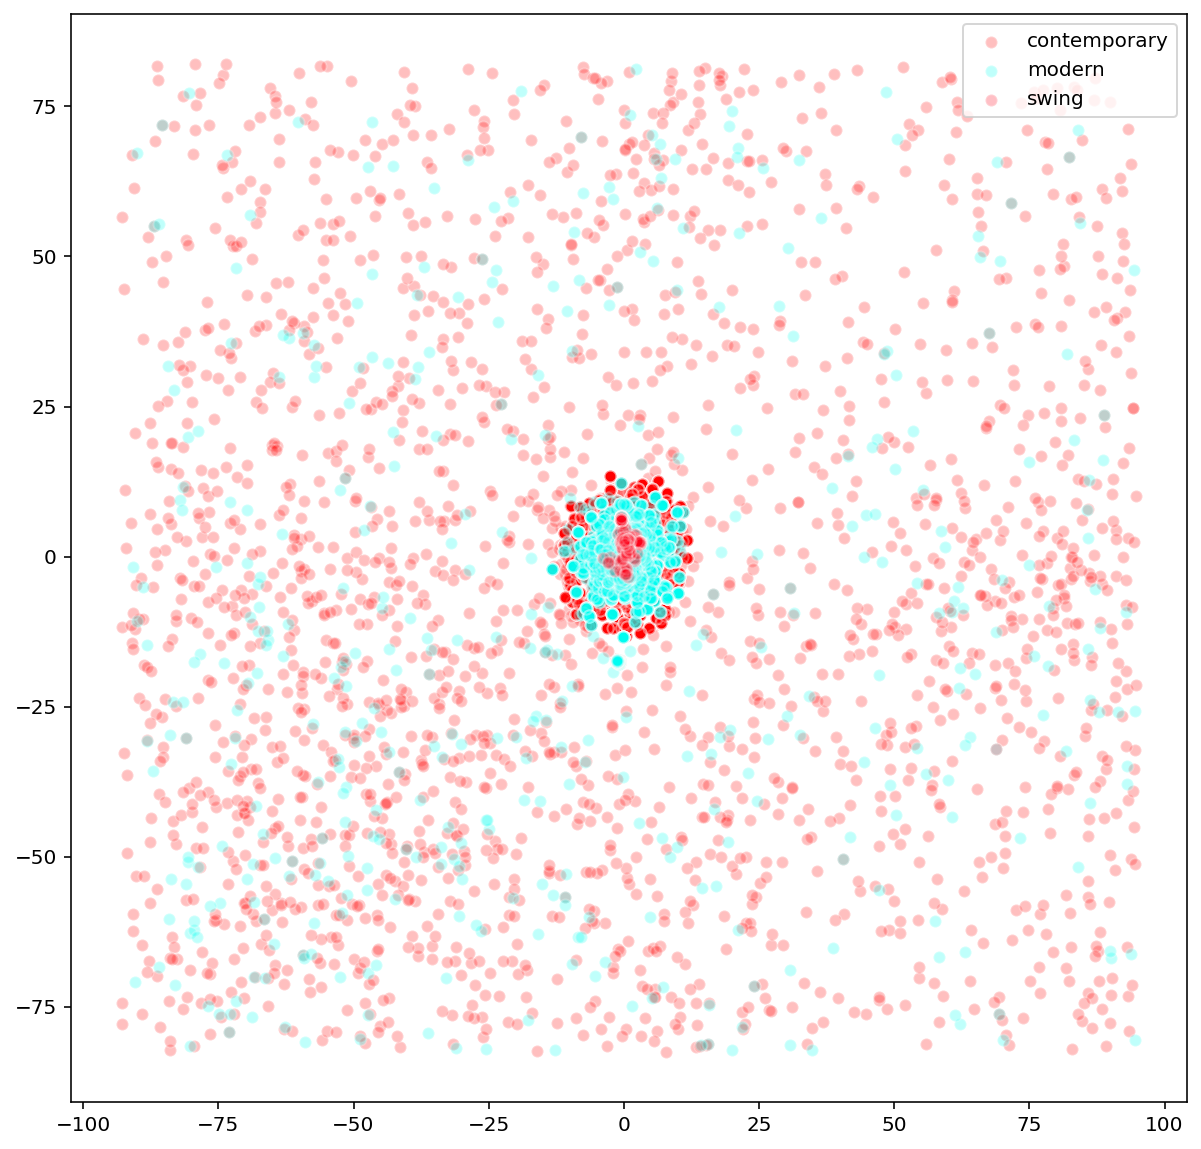

In [46]:
plot_indicator_2d(outlier_remover.fit_transform(df),column_store._timeperiod_era,column_store._umap_2d)

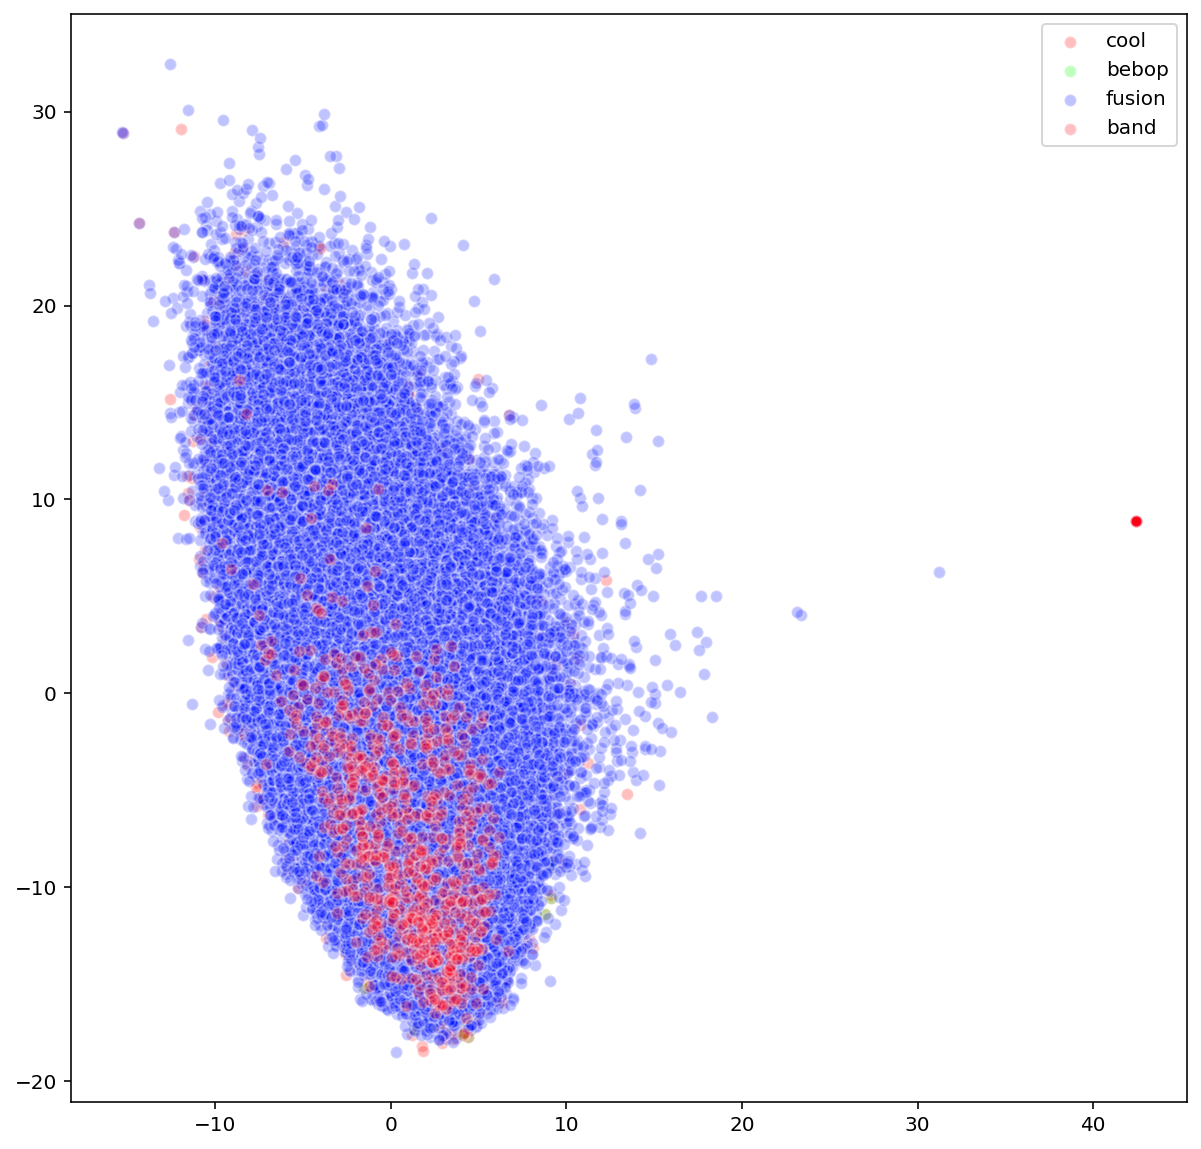

In [47]:
plot_indicator_2d(df,column_store._timeperiod_period,column_store._pca_2d)

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


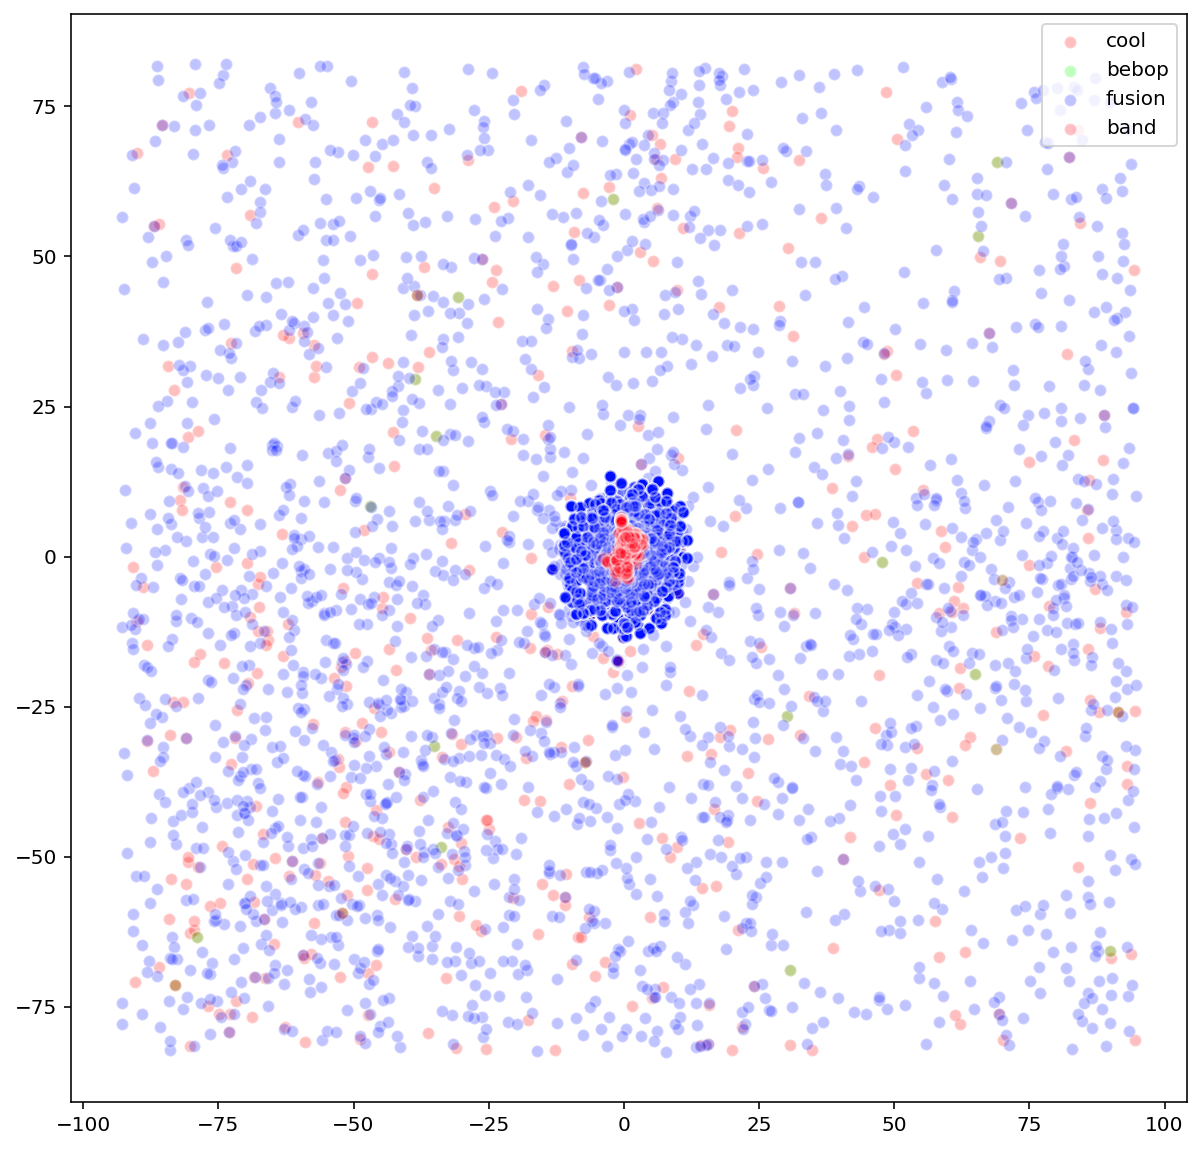

In [48]:
plot_indicator_2d(outlier_remover.fit_transform(df),column_store._timeperiod_period,column_store._umap_2d)

From the above visualizations of the high-level features obtained from the pre-trained computer vision model, we see that there are no clear lines to draw among the dimensionally reduced embeddings according to the indicators we are using in this analysis. While this is unfortunate, it is not completely unexpected, as cover images can vary essentially limitlessly and as such grouping them together according to our indicators is a difficult task to say the least. Nonetheless, we'll use these embeddings as input features for our machine learning models, after reducing the dimensions to 10. For this purpose we will use UMAP, as it seems to perform better in the 2d visualization scenario, being able to separate data points more effectively, and in less of a jammed together fashion as in the PCA examples.